In [1]:
from option import args
import torch
import utility
import data
import utils
import model
import loss
from trainer import Trainer
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
torch.manual_seed(args.seed)
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


number of common Subjects  171


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args.block_size

(32, 32, 4)

In [3]:
args.no_vols = 10
args.growth = 32
print(args.no_vols)
args.run_name = f"jupyter_40_epoch,{args.no_vols}_vols,blk_{args.block_size},loss_{args.loss},growth_{args.growth}"
print(args.run_name)
args.debug= True

10
jupyter_40_epoch,10_vols,blk_(32, 32, 4),loss_0.5*L1+0.5*MSE,growth_32


In [4]:

ids = utils.get_ids()
ids.sort()
total_vols = args.no_vols
ids = ids[:total_vols]
loader = data.Data(args,ids= ids,debug = False)  
checkpoint = utility.checkpoint(args)
model = model.Model(args, checkpoint)
loss = loss.Loss(args, checkpoint)
logger = SummaryWriter('runs/'+ args.run_name)

[1.2, 1.2, 1.2]
100610 loaded
102311 loaded
102816 loaded
104416 loaded
105923 loaded
108323 loaded
109123 loaded
Loading Done
Making model...
Preparing loss function:
0.500 * L1
0.500 * MSE


In [5]:
# model
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"number of parameters are {round(params/1000000,2)}M")

number of parameters are 7.8M


In [6]:
for iteration, (lr_tensor, hr_tensor,pnts,scale) in enumerate(loader.testing_data, 1):
    print("hr_tensor_adc" , hr_tensor.cpu()[:,:,:,0].max().item(),hr_tensor.cpu()[:,:,:,0].min().item())
    print("hr_tensor_fa" , hr_tensor.cpu()[:,:,:,1].max().item(),hr_tensor.cpu()[:,:,:,1].min().item())
    print("hr_tensor_color_fa" , hr_tensor.cpu()[:,:,:,2:].max().item(),hr_tensor.cpu()[:,:,:,2:].min().item())
    break
#     print("lr_tensor" , lr_tensor.cpu()[:,:,:,0].max().item(),lr_tensor.cpu()[:,:,:,0].min().item())

hr_tensor_adc 1.0 0.0
hr_tensor_fa 1.0 0.0
hr_tensor_color_fa 1.0 0.0


In [7]:
hr = hr_tensor.cpu()[:,:,:,1]
lr = lr_tensor.cpu()[:,:,:,0]

In [8]:
hr.shape,lr.shape

(torch.Size([216, 262, 201]), torch.Size([335, 32, 32, 7]))

In [9]:
histogram, bin_edges = np.histogram(hr, bins=256, range=(0, 1))


In [10]:
%matplotlib 

Using matplotlib backend: <object object at 0x7fb907bfc360>


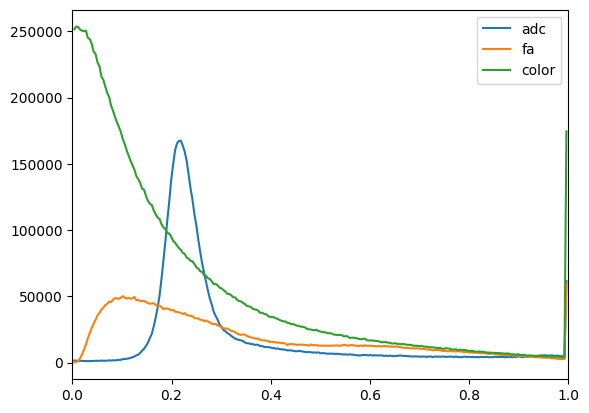

In [11]:
%matplotlib inline
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

hr = hr_tensor.cpu()[:,:,:,0]
histogram, bin_edges = np.histogram(hr, bins=256, range=(0, 1))
plt.plot(bin_edges[1:-1], histogram[1:],label="adc")
hr = hr_tensor.cpu()[:,:,:,1]
histogram, bin_edges = np.histogram(hr, bins=256, range=(0, 1))
plt.plot(bin_edges[1:-1], histogram[1:],label="fa")
hr = hr_tensor.cpu()[:,:,:,2:]
histogram, bin_edges = np.histogram(hr, bins=256, range=(0, 1))
plt.plot(bin_edges[1:-1], histogram[1:],label="color")
plt.legend()

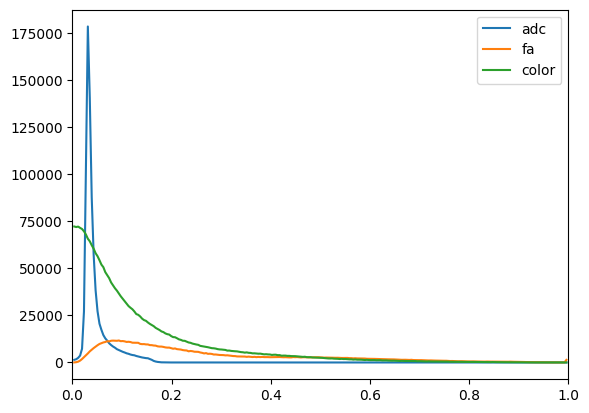

In [11]:
%matplotlib inline
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

hr = hr_tensor.cpu()[:,:,:,0]
histogram, bin_edges = np.histogram(hr, bins=256, range=(0, 1))
plt.plot(bin_edges[1:-1], histogram[1:],label="adc")
hr = hr_tensor.cpu()[:,:,:,1]
histogram, bin_edges = np.histogram(hr, bins=256, range=(0, 1))
plt.plot(bin_edges[1:-1], histogram[1:],label="fa")
hr = hr_tensor.cpu()[:,:,:,2:]
histogram, bin_edges = np.histogram(hr, bins=256, range=(0, 1))
plt.plot(bin_edges[1:-1], histogram[1:],label="color")
plt.legend()

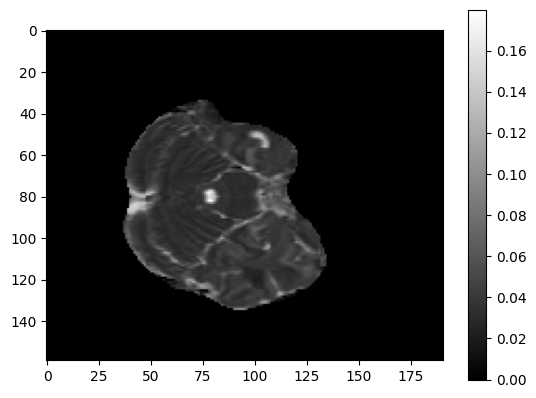

In [12]:
plt.imshow(hr_tensor.cpu()[:,:,50,0],cmap='gray')
plt.colorbar()

In [13]:
from trainer import Trainer
t = Trainer(args, loader, model, loss, checkpoint,logger)

In [14]:
for iteration, (lr_tensor, hr_tensor,scale) in enumerate(loader.training_data, 1):
    print(lr_tensor.shape,hr_tensor.shape,scale)
    break

torch.Size([16, 32, 32, 4, 7]) torch.Size([16, 32, 32, 4, 5]) (1, 1, 1)


In [15]:
lr_tensor[...,6].shape

torch.Size([16, 32, 32, 4])

In [16]:
lr_tensor[0,:,:,0,6].shape

torch.Size([32, 32])

In [17]:
model

Model(
  (model): DMRI_SR(
    (encoder): RDN(
      (SFENet1): Conv3d(7, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (SFENet2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (RDBs): ModuleList(
        (0-4): 5 x RDB(
          (convs): Sequential(
            (0): RDB_Conv(
              (conv): Sequential(
                (0): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): ReLU()
              )
            )
            (1): RDB_Conv(
              (conv): Sequential(
                (0): Conv3d(96, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): ReLU()
              )
            )
            (2): RDB_Conv(
              (conv): Sequential(
                (0): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): ReLU()
              )
            )
            (3): RDB_Conv(
              (c

In [18]:
for batch, (lr_tensor, hr_tensor,scale) in enumerate(loader.training_data):
    lr_tensor = lr_tensor.to('cuda').float()  # ranges from [0, 1]
    hr_tensor = hr_tensor.to('cuda').float()  # ranges from [0, 1]
    lr_tensor = torch.permute(lr_tensor, (0,4,1,2,3))
    break


In [19]:
lr_tensor.shape

torch.Size([16, 7, 32, 32, 4])

input = [16, 7, 32, 32, 4]

encoder output = torch.Size([16, 64, 32, 32, 4])

In [20]:
t.train()

0
stablizing
[Epoch 1]	Learning rate: 5.00e-4


[L1: 0.0271][MSE: 0.0061][Total: 0.0332]: 100%|██████████████████████| 651/651 [01:57<00:00,  5.54it/s, scale=(1, 1, 1)]


In [21]:
lr_tensor, hr_tensor,pnts,scale = next(iter(loader.testing_data))
print(lr_tensor.shape)
lr_tensor = lr_tensor.to(t.device)
hr_tensor = hr_tensor.to(t.device)
lr_tensor = torch.permute(lr_tensor, (0,4,1,2,3))

torch.Size([391, 32, 32, 4, 7])


In [22]:
lr_tensor.shape

torch.Size([391, 7, 32, 32, 4])

In [23]:
with torch.no_grad():
    pred = t.model.forward(lr_tensor,scale)
pred = torch.permute(pred, (0,2,3,4,1)).float()

In [24]:
pred.shape

torch.Size([391, 54, 54, 7, 5])

In [34]:

torch.cuda.empty_cache()

In [26]:
# %%timeit
psnr, ssim = utility.compute_psnr_ssim(hr_tensor,pred,pnts)

In [27]:
psnr,ssim

(20.31302524028584, 0.7963067659270899)

In [28]:
def recon(x,lr,vol_size):
    num_blk = x.shape[0]
    vol = torch.empty(size=vol_size)
    for i in range(num_blk):
        vol[lr[i][0]:lr[i][1]+1,lr[i][2]:lr[i][3]+1,lr[i][4]:lr[i][5]+1,...] = x[i,...]
    return vol

In [29]:
rec = recon(pred,pnts,vol_size=hr_tensor.shape)

In [30]:
rec.shape

torch.Size([246, 295, 246, 5])

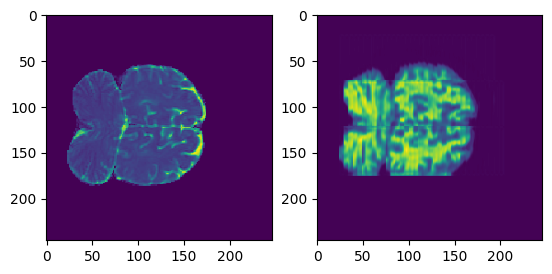

In [31]:
fig ,ax = plt.subplots(1,2)
ax[0].imshow(hr_tensor.cpu()[:,80,:,0])
ax[1].imshow(rec[:,80,:,0])
# plt.show()

In [32]:
temp = []
for i in range(50):
    t.train()
    t.test()
    temp.append(i)


1
[Epoch 2]	Learning rate: 5.00e-4


[L1: 3.1219][MSE: 7275.6309][Total: 7278.7529]:   7%|▋        | 3361/44883 [01:36<11:21, 60.89it/s, scale=[1.2 1.2 1.2]]

Skip this batch 3343! (Loss: 478804.84375)
Skip this batch 3344! (Loss: 456212.96875)
Skip this batch 3345! (Loss: 144122.21875)
Skip this batch 3346! (Loss: 222728.703125)
Skip this batch 3347! (Loss: 2336834.0)
Skip this batch 3348! (Loss: 1502031.125)
Skip this batch 3349! (Loss: 2120441.75)
Skip this batch 3350! (Loss: 1955045.375)
Skip this batch 3351! (Loss: 3476160.75)
Skip this batch 3352! (Loss: 301276.59375)
Skip this batch 3353! (Loss: 144998.359375)
Skip this batch 3354! (Loss: 177430.734375)
Skip this batch 3355! (Loss: 5245811.0)
Skip this batch 3356! (Loss: 210663.875)
Skip this batch 3357! (Loss: 1058252.0)
Skip this batch 3358! (Loss: 1922511.375)
Skip this batch 3359! (Loss: 1020876.1875)
Skip this batch 3360! (Loss: 1659125.25)


[L1: 3.1219][MSE: 7275.6309][Total: 7278.7529]:   8%|▋        | 3379/44883 [01:36<09:15, 74.75it/s, scale=[1.2 1.2 1.2]]

Skip this batch 3361! (Loss: 1281395.875)
Skip this batch 3362! (Loss: 150216.515625)
Skip this batch 3363! (Loss: 567443.25)
Skip this batch 3364! (Loss: 269706.6875)
Skip this batch 3365! (Loss: 3266711.0)
Skip this batch 3366! (Loss: 246422.453125)
Skip this batch 3367! (Loss: 621699.8125)
Skip this batch 3368! (Loss: 311573.90625)
Skip this batch 3369! (Loss: 985733.1875)
Skip this batch 3370! (Loss: 1501258.75)
Skip this batch 3371! (Loss: 2213872.75)
Skip this batch 3372! (Loss: 198571.328125)
Skip this batch 3373! (Loss: 1219368.5)
Skip this batch 3374! (Loss: 247505.65625)
Skip this batch 3375! (Loss: 1292642.875)
Skip this batch 3376! (Loss: 349555.84375)
Skip this batch 3377! (Loss: 2453353.25)
Skip this batch 3378! (Loss: 187986.96875)


[L1: 6.0986][MSE: 13214.1045][Total: 13220.2051]:   8%|▌      | 3397/44883 [01:36<08:39, 79.86it/s, scale=[1.8 1.7 1.8]]

Skip this batch 3379! (Loss: 1046880.625)
Skip this batch 3380! (Loss: 1815785.5)
Skip this batch 3381! (Loss: 255591.671875)
Skip this batch 3382! (Loss: 1369755.625)
Skip this batch 3383! (Loss: 256592.5)
Skip this batch 3384! (Loss: 2245264.75)
Skip this batch 3385! (Loss: 6273072.5)
Skip this batch 3386! (Loss: 2397216.25)
Skip this batch 3387! (Loss: 184147.3125)
Skip this batch 3388! (Loss: 3484354.25)
Skip this batch 3389! (Loss: 306138.21875)
Skip this batch 3390! (Loss: 1997661.5)
Skip this batch 3391! (Loss: 199630.609375)
Skip this batch 3392! (Loss: 2421827.5)
Skip this batch 3393! (Loss: 1042561.125)
Skip this batch 3394! (Loss: 268381.3125)
Skip this batch 3395! (Loss: 240536.84375)
Skip this batch 3396! (Loss: 260087.0)


[L1: 9.5681][MSE: 22041.8926][Total: 22051.4629]:   8%|▌      | 3406/44883 [01:36<08:29, 81.42it/s, scale=[1.3 1.2 1.3]]

Skip this batch 3397! (Loss: 262835.78125)
Skip this batch 3398! (Loss: 3770911.0)
Skip this batch 3399! (Loss: 2166648.25)
Skip this batch 3400! (Loss: 887461.8125)
Skip this batch 3401! (Loss: 321739.0)
Skip this batch 3402! (Loss: 144128.40625)
Skip this batch 3403! (Loss: 340516.1875)
Skip this batch 3404! (Loss: 339042.90625)
Skip this batch 3405! (Loss: 3132281.25)
Skip this batch 3406! (Loss: 2706752.5)
Skip this batch 3407! (Loss: 2008547.25)
Skip this batch 3408! (Loss: 2072068.75)
Skip this batch 3409! (Loss: 2031716.125)
Skip this batch 3410! (Loss: 336527.6875)
Skip this batch 3411! (Loss: 439659.15625)
Skip this batch 3412! (Loss: 1137667.625)
Skip this batch 3413! (Loss: 1439907.875)
Skip this batch 3414! (Loss: 1980568.0)


[L1: 12.8697][MSE: 29346.9629][Total: 29359.8340]:   8%|▍     | 3425/44883 [01:37<08:04, 85.51it/s, scale=[1.  1.2 1.1]]

Skip this batch 3415! (Loss: 1492260.0)
Skip this batch 3416! (Loss: 2814860.0)
Skip this batch 3417! (Loss: 192403.28125)
Skip this batch 3418! (Loss: 1117651.75)
Skip this batch 3419! (Loss: 1092113.5)
Skip this batch 3420! (Loss: 295255.25)
Skip this batch 3421! (Loss: 5313276.0)
Skip this batch 3422! (Loss: 766778.9375)
Skip this batch 3423! (Loss: 1236542.0)
Skip this batch 3424! (Loss: 243175.546875)
Skip this batch 3425! (Loss: 531959.25)
Skip this batch 3426! (Loss: 1281246.75)
Skip this batch 3427! (Loss: 1227013.375)
Skip this batch 3428! (Loss: 3235510.25)
Skip this batch 3429! (Loss: 1974128.25)
Skip this batch 3430! (Loss: 1168052.5)
Skip this batch 3431! (Loss: 604046.6875)
Skip this batch 3432! (Loss: 286254.125)


[L1: 16.1935][MSE: 37123.5312][Total: 37139.7266]:   8%|▍     | 3444/44883 [01:37<07:51, 87.83it/s, scale=[1.7 1.7 1.8]]

Skip this batch 3433! (Loss: 3270484.0)
Skip this batch 3434! (Loss: 1850084.25)
Skip this batch 3435! (Loss: 483398.71875)
Skip this batch 3436! (Loss: 2726473.5)
Skip this batch 3437! (Loss: 249687.84375)
Skip this batch 3438! (Loss: 155951.046875)
Skip this batch 3439! (Loss: 292373.3125)
Skip this batch 3440! (Loss: 453578.15625)
Skip this batch 3441! (Loss: 228488.84375)
Skip this batch 3442! (Loss: 170738.609375)
Skip this batch 3443! (Loss: 270382.9375)
Skip this batch 3444! (Loss: 2928521.75)
Skip this batch 3445! (Loss: 1667391.0)
Skip this batch 3446! (Loss: 165135.546875)
Skip this batch 3447! (Loss: 2932383.0)
Skip this batch 3448! (Loss: 240294.828125)
Skip this batch 3449! (Loss: 2286887.75)
Skip this batch 3450! (Loss: 1961102.25)


[L1: 19.4898][MSE: 44915.1289][Total: 44934.6211]:   8%|▍     | 3462/44883 [01:37<07:51, 87.88it/s, scale=[1.7 1.8 1.8]]

Skip this batch 3451! (Loss: 1291865.875)
Skip this batch 3452! (Loss: 974626.75)
Skip this batch 3453! (Loss: 1224244.0)
Skip this batch 3454! (Loss: 4279416.0)
Skip this batch 3455! (Loss: 2465608.5)
Skip this batch 3456! (Loss: 363742.0625)
Skip this batch 3457! (Loss: 314475.8125)
Skip this batch 3458! (Loss: 2178888.25)
Skip this batch 3459! (Loss: 207898.71875)
Skip this batch 3460! (Loss: 1561044.25)
Skip this batch 3461! (Loss: 2969849.75)
Skip this batch 3462! (Loss: 1356499.75)
Skip this batch 3463! (Loss: 3241479.25)
Skip this batch 3464! (Loss: 2732265.25)
Skip this batch 3465! (Loss: 731723.125)
Skip this batch 3466! (Loss: 310128.875)
Skip this batch 3467! (Loss: 3401578.75)
Skip this batch 3468! (Loss: 255366.0625)
Skip this batch 3469! (Loss: 233719.90625)


[L1: 23.6612][MSE: 57179.0703][Total: 57202.7383]:   8%|▍     | 3480/44883 [01:37<07:52, 87.62it/s, scale=[1.5 1.5 1.5]]

Skip this batch 3470! (Loss: 160715.78125)
Skip this batch 3471! (Loss: 4215647.5)
Skip this batch 3472! (Loss: 2329037.75)
Skip this batch 3473! (Loss: 4511454.0)
Skip this batch 3474! (Loss: 1452575.875)
Skip this batch 3475! (Loss: 3079811.5)
Skip this batch 3476! (Loss: 3238823.0)
Skip this batch 3477! (Loss: 2731655.75)
Skip this batch 3478! (Loss: 207659.84375)
Skip this batch 3479! (Loss: 4333707.5)
Skip this batch 3480! (Loss: 2098040.0)
Skip this batch 3481! (Loss: 3749152.5)
Skip this batch 3482! (Loss: 1149705.125)
Skip this batch 3483! (Loss: 278776.96875)
Skip this batch 3484! (Loss: 3131248.0)
Skip this batch 3485! (Loss: 180500.296875)
Skip this batch 3486! (Loss: 2165008.75)
Skip this batch 3487! (Loss: 4622491.5)


[L1: 27.6480][MSE: 68825.4609][Total: 68853.1328]:   8%|▍     | 3500/44883 [01:38<07:50, 88.00it/s, scale=[1.3 1.2 1.3]]

Skip this batch 3488! (Loss: 2892484.0)
Skip this batch 3489! (Loss: 1899366.625)
Skip this batch 3490! (Loss: 1596505.5)
Skip this batch 3491! (Loss: 2255032.0)
Skip this batch 3492! (Loss: 290417.9375)
Skip this batch 3493! (Loss: 2881571.25)
Skip this batch 3494! (Loss: 2096677.375)
Skip this batch 3495! (Loss: 196397.1875)
Skip this batch 3496! (Loss: 8558667.0)
Skip this batch 3497! (Loss: 2081913.25)
Skip this batch 3498! (Loss: 312312.28125)
Skip this batch 3499! (Loss: 972334.6875)
Skip this batch 3500! (Loss: 609844.375)
Skip this batch 3501! (Loss: 1330102.875)
Skip this batch 3502! (Loss: 180711.953125)
Skip this batch 3503! (Loss: 811600.8125)
Skip this batch 3504! (Loss: 3384377.25)
Skip this batch 3505! (Loss: 180659.890625)


[L1: 29.9925][MSE: 73023.7266][Total: 73053.7344]:   8%|▍     | 3520/44883 [01:38<07:47, 88.56it/s, scale=[1.8 1.8 1.8]]

Skip this batch 3506! (Loss: 196194.484375)
Skip this batch 3507! (Loss: 618516.5)
Skip this batch 3508! (Loss: 271514.6875)
Skip this batch 3509! (Loss: 1791955.5)
Skip this batch 3510! (Loss: 463831.59375)
Skip this batch 3511! (Loss: 350234.28125)
Skip this batch 3512! (Loss: 215714.40625)
Skip this batch 3513! (Loss: 144986.9375)
Skip this batch 3514! (Loss: 305418.625)
Skip this batch 3515! (Loss: 260326.34375)
Skip this batch 3516! (Loss: 1446725.625)
Skip this batch 3517! (Loss: 195468.609375)
Skip this batch 3518! (Loss: 226796.28125)
Skip this batch 3519! (Loss: 2061841.25)
Skip this batch 3520! (Loss: 1726218.875)
Skip this batch 3521! (Loss: 184630.84375)
Skip this batch 3522! (Loss: 442161.09375)
Skip this batch 3523! (Loss: 246187.46875)
Skip this batch 3524! (Loss: 3339822.5)


[L1: 33.2446][MSE: 81046.0859][Total: 81079.3203]:   8%|▍     | 3540/44883 [01:38<07:42, 89.34it/s, scale=[1.9 2.  1.9]]

Skip this batch 3525! (Loss: 327955.34375)
Skip this batch 3526! (Loss: 390557.90625)
Skip this batch 3527! (Loss: 3813652.25)
Skip this batch 3528! (Loss: 234390.59375)
Skip this batch 3529! (Loss: 2834801.5)
Skip this batch 3530! (Loss: 736299.6875)
Skip this batch 3531! (Loss: 3134351.75)
Skip this batch 3532! (Loss: 269343.625)
Skip this batch 3533! (Loss: 811376.4375)
Skip this batch 3534! (Loss: 1458785.5)
Skip this batch 3535! (Loss: 1958894.25)
Skip this batch 3536! (Loss: 3291393.25)
Skip this batch 3537! (Loss: 1965463.375)
Skip this batch 3538! (Loss: 2444932.5)
Skip this batch 3539! (Loss: 1817453.0)
Skip this batch 3540! (Loss: 169253.828125)
Skip this batch 3541! (Loss: 595687.25)
Skip this batch 3542! (Loss: 345060.8125)


[L1: 36.6694][MSE: 89939.5000][Total: 89976.1719]:   8%|▍     | 3560/44883 [01:38<07:43, 89.24it/s, scale=[1.6 1.7 1.7]]

Skip this batch 3543! (Loss: 466673.8125)
Skip this batch 3544! (Loss: 2349697.75)
Skip this batch 3545! (Loss: 472399.75)
Skip this batch 3546! (Loss: 3961886.25)
Skip this batch 3547! (Loss: 1385369.875)
Skip this batch 3548! (Loss: 4086738.25)
Skip this batch 3549! (Loss: 171139.8125)
Skip this batch 3550! (Loss: 187260.6875)
Skip this batch 3551! (Loss: 850100.125)
Skip this batch 3552! (Loss: 4678225.0)
Skip this batch 3553! (Loss: 1062451.625)
Skip this batch 3554! (Loss: 1534625.75)
Skip this batch 3555! (Loss: 3447685.25)
Skip this batch 3556! (Loss: 1122936.875)
Skip this batch 3557! (Loss: 2008371.625)
Skip this batch 3558! (Loss: 2871276.0)
Skip this batch 3559! (Loss: 169179.640625)
Skip this batch 3560! (Loss: 1527550.75)


[L1: 36.6694][MSE: 89939.5000][Total: 89976.1719]:   8%|▍     | 3575/44883 [01:38<07:39, 89.80it/s, scale=[1.6 1.7 1.7]]

Skip this batch 3561! (Loss: 265273.40625)
Skip this batch 3562! (Loss: 3318424.75)
Skip this batch 3563! (Loss: 280205.375)
Skip this batch 3564! (Loss: 162457.671875)
Skip this batch 3565! (Loss: 2266265.0)
Skip this batch 3566! (Loss: 231694.5)
Skip this batch 3567! (Loss: 1718321.375)
Skip this batch 3568! (Loss: 1590021.125)
Skip this batch 3569! (Loss: 668959.125)
Skip this batch 3570! (Loss: 1818738.375)
Skip this batch 3571! (Loss: 239260.109375)
Skip this batch 3572! (Loss: 2894464.75)
Skip this batch 3573! (Loss: 401272.46875)
Skip this batch 3574! (Loss: 1370097.875)
Skip this batch 3575! (Loss: 3774701.75)
Skip this batch 3576! (Loss: 2890068.0)
Skip this batch 3577! (Loss: 2409028.0)
Skip this batch 3578! (Loss: 1292125.25)
Skip this batch 3579! (Loss: 163556.4375)


[L1: 39.8447][MSE: 97578.0078][Total: 97617.8750]:   8%|▍     | 3593/44883 [01:39<07:43, 89.01it/s, scale=[1.8 1.7 1.9]]

Skip this batch 3580! (Loss: 1401857.75)
Skip this batch 3581! (Loss: 2664822.75)
Skip this batch 3582! (Loss: 3249424.5)
Skip this batch 3583! (Loss: 187945.171875)
Skip this batch 3584! (Loss: 1872941.375)
Skip this batch 3585! (Loss: 1288998.0)
Skip this batch 3586! (Loss: 3312713.0)
Skip this batch 3587! (Loss: 289795.9375)
Skip this batch 3588! (Loss: 288368.34375)
Skip this batch 3589! (Loss: 181886.828125)
Skip this batch 3590! (Loss: 195837.28125)
Skip this batch 3591! (Loss: 4059751.25)
Skip this batch 3592! (Loss: 172346.0625)
Skip this batch 3593! (Loss: 960579.625)
Skip this batch 3594! (Loss: 567345.4375)
Skip this batch 3595! (Loss: 208444.859375)
Skip this batch 3596! (Loss: 1714202.25)
Skip this batch 3597! (Loss: 3793779.25)


[L1: 42.9368][MSE: 105247.1250][Total: 105290.0781]:   8%|▎   | 3612/44883 [01:39<07:37, 90.16it/s, scale=[1.4 1.4 1.3]]

Skip this batch 3598! (Loss: 1134191.0)
Skip this batch 3599! (Loss: 2737832.5)
Skip this batch 3600! (Loss: 691085.0)
Skip this batch 3601! (Loss: 232067.015625)
Skip this batch 3602! (Loss: 619483.5625)
Skip this batch 3603! (Loss: 1362405.125)
Skip this batch 3604! (Loss: 2352620.25)
Skip this batch 3605! (Loss: 2021983.625)
Skip this batch 3606! (Loss: 369760.5)
Skip this batch 3607! (Loss: 1882853.75)
Skip this batch 3608! (Loss: 1932640.625)
Skip this batch 3609! (Loss: 2199761.5)
Skip this batch 3610! (Loss: 3480379.0)
Skip this batch 3611! (Loss: 271480.90625)
Skip this batch 3612! (Loss: 2830012.0)
Skip this batch 3613! (Loss: 2410243.25)
Skip this batch 3614! (Loss: 2099296.75)
Skip this batch 3615! (Loss: 155756.453125)
Skip this batch 3616! (Loss: 1446282.5)


[L1: 46.2095][MSE: 112958.3438][Total: 113004.5703]:   8%|▎   | 3632/44883 [01:39<07:38, 89.89it/s, scale=[1.8 1.8 1.7]]

Skip this batch 3617! (Loss: 411901.65625)
Skip this batch 3618! (Loss: 1974018.125)
Skip this batch 3619! (Loss: 1758768.875)
Skip this batch 3620! (Loss: 220543.734375)
Skip this batch 3621! (Loss: 409273.96875)
Skip this batch 3622! (Loss: 1990046.875)
Skip this batch 3623! (Loss: 197961.03125)
Skip this batch 3624! (Loss: 2303545.0)
Skip this batch 3625! (Loss: 2255630.5)
Skip this batch 3626! (Loss: 1343098.75)
Skip this batch 3627! (Loss: 1732210.5)
Skip this batch 3628! (Loss: 219795.9375)
Skip this batch 3629! (Loss: 186024.140625)
Skip this batch 3630! (Loss: 1901855.25)
Skip this batch 3631! (Loss: 2159514.0)
Skip this batch 3632! (Loss: 144117.109375)
Skip this batch 3633! (Loss: 4847280.5)
Skip this batch 3634! (Loss: 397964.25)


[L1: 49.3702][MSE: 121002.6484][Total: 121052.0547]:   8%|▎   | 3651/44883 [01:39<07:37, 90.22it/s, scale=[1.6 1.7 1.7]]

Skip this batch 3635! (Loss: 2157105.0)
Skip this batch 3636! (Loss: 2506519.0)
Skip this batch 3637! (Loss: 3063842.75)
Skip this batch 3638! (Loss: 306259.59375)
Skip this batch 3639! (Loss: 210062.84375)
Skip this batch 3640! (Loss: 3220782.25)
Skip this batch 3641! (Loss: 271718.90625)
Skip this batch 3642! (Loss: 6739400.0)
Skip this batch 3643! (Loss: 2386181.0)
Skip this batch 3644! (Loss: 207262.015625)
Skip this batch 3645! (Loss: 205549.234375)
Skip this batch 3646! (Loss: 2344577.25)
Skip this batch 3647! (Loss: 3147871.5)
Skip this batch 3648! (Loss: 3020020.0)
Skip this batch 3649! (Loss: 321676.03125)
Skip this batch 3650! (Loss: 184026.875)
Skip this batch 3651! (Loss: 197807.21875)
Skip this batch 3652! (Loss: 225522.578125)
Skip this batch 3653! (Loss: 2381346.5)


[L1: 52.3115][MSE: 128715.1328][Total: 128767.4766]:   8%|▎   | 3670/44883 [01:39<07:43, 88.86it/s, scale=[1.3 1.3 1.5]]

Skip this batch 3654! (Loss: 2109020.25)
Skip this batch 3655! (Loss: 161812.046875)
Skip this batch 3656! (Loss: 196304.109375)
Skip this batch 3657! (Loss: 2578823.25)
Skip this batch 3658! (Loss: 1717297.25)
Skip this batch 3659! (Loss: 198925.359375)
Skip this batch 3660! (Loss: 2064358.625)
Skip this batch 3661! (Loss: 189533.96875)
Skip this batch 3662! (Loss: 207707.421875)
Skip this batch 3663! (Loss: 1400735.125)
Skip this batch 3664! (Loss: 544755.5)
Skip this batch 3665! (Loss: 1629194.25)
Skip this batch 3666! (Loss: 2587599.25)
Skip this batch 3667! (Loss: 4290734.0)
Skip this batch 3668! (Loss: 830495.6875)
Skip this batch 3669! (Loss: 229511.140625)
Skip this batch 3670! (Loss: 2335020.5)
Skip this batch 3671! (Loss: 2069778.25)


[L1: 55.3219][MSE: 135618.2656][Total: 135673.6250]:   8%|▎   | 3689/44883 [01:40<07:39, 89.69it/s, scale=[1.4 1.4 1.3]]

Skip this batch 3672! (Loss: 536499.3125)
Skip this batch 3673! (Loss: 2077677.125)
Skip this batch 3674! (Loss: 334173.625)
Skip this batch 3675! (Loss: 1979669.5)
Skip this batch 3676! (Loss: 260805.671875)
Skip this batch 3677! (Loss: 1555823.5)
Skip this batch 3678! (Loss: 2249718.25)
Skip this batch 3679! (Loss: 997430.5625)
Skip this batch 3680! (Loss: 1683104.5)
Skip this batch 3681! (Loss: 342995.0625)
Skip this batch 3682! (Loss: 196829.125)
Skip this batch 3683! (Loss: 343419.125)
Skip this batch 3684! (Loss: 2556776.0)
Skip this batch 3685! (Loss: 1845631.625)
Skip this batch 3686! (Loss: 265214.96875)
Skip this batch 3687! (Loss: 2975277.75)
Skip this batch 3688! (Loss: 144287.984375)
Skip this batch 3689! (Loss: 262213.46875)
Skip this batch 3690! (Loss: 1007706.25)


[L1: 57.6865][MSE: 140463.8281][Total: 140521.5625]:   8%|▎   | 3708/44883 [01:40<07:41, 89.21it/s, scale=[1.5 1.5 1.5]]

Skip this batch 3691! (Loss: 1675310.875)
Skip this batch 3692! (Loss: 1038799.125)
Skip this batch 3693! (Loss: 1927033.75)
Skip this batch 3694! (Loss: 1219767.75)
Skip this batch 3695! (Loss: 3569293.0)
Skip this batch 3696! (Loss: 459870.1875)
Skip this batch 3697! (Loss: 264674.96875)
Skip this batch 3698! (Loss: 177961.5625)
Skip this batch 3699! (Loss: 188385.375)
Skip this batch 3700! (Loss: 189442.984375)
Skip this batch 3701! (Loss: 350430.65625)
Skip this batch 3702! (Loss: 626190.75)
Skip this batch 3703! (Loss: 377272.8125)
Skip this batch 3704! (Loss: 303964.625)
Skip this batch 3705! (Loss: 1223557.125)
Skip this batch 3706! (Loss: 2585032.5)
Skip this batch 3707! (Loss: 2463318.25)
Skip this batch 3708! (Loss: 479610.40625)


[L1: 60.4632][MSE: 146470.3750][Total: 146530.8594]:   8%|▎   | 3726/44883 [01:40<07:45, 88.45it/s, scale=[1.3 1.3 1.5]]

Skip this batch 3709! (Loss: 542931.1875)
Skip this batch 3710! (Loss: 510949.5)
Skip this batch 3711! (Loss: 2360611.75)
Skip this batch 3712! (Loss: 2373726.25)
Skip this batch 3713! (Loss: 435349.0)
Skip this batch 3714! (Loss: 1259478.625)
Skip this batch 3715! (Loss: 1519454.875)
Skip this batch 3716! (Loss: 3585302.0)
Skip this batch 3717! (Loss: 1543499.625)
Skip this batch 3718! (Loss: 2015239.25)
Skip this batch 3719! (Loss: 185689.140625)
Skip this batch 3720! (Loss: 423459.1875)
Skip this batch 3721! (Loss: 1320431.0)
Skip this batch 3722! (Loss: 1285425.375)
Skip this batch 3723! (Loss: 1742176.625)
Skip this batch 3724! (Loss: 1630420.875)
Skip this batch 3725! (Loss: 1483969.625)
Skip this batch 3726! (Loss: 1285681.0)


[L1: 63.7080][MSE: 154342.1406][Total: 154405.8750]:   8%|▎   | 3745/44883 [01:40<07:43, 88.78it/s, scale=[1.1 1.1 1.1]]

Skip this batch 3727! (Loss: 492416.65625)
Skip this batch 3728! (Loss: 1882661.125)
Skip this batch 3729! (Loss: 3183828.25)
Skip this batch 3730! (Loss: 1989323.0)
Skip this batch 3731! (Loss: 2325360.0)
Skip this batch 3732! (Loss: 2711037.5)
Skip this batch 3733! (Loss: 874808.4375)
Skip this batch 3734! (Loss: 1830444.25)
Skip this batch 3735! (Loss: 351829.25)
Skip this batch 3736! (Loss: 895586.4375)
Skip this batch 3737! (Loss: 739558.0)
Skip this batch 3738! (Loss: 4049406.75)
Skip this batch 3739! (Loss: 185803.546875)
Skip this batch 3740! (Loss: 2122885.75)
Skip this batch 3741! (Loss: 769558.75)
Skip this batch 3742! (Loss: 364998.5)
Skip this batch 3743! (Loss: 259232.328125)
Skip this batch 3744! (Loss: 1590914.0)


[L1: 65.8527][MSE: 158152.2188][Total: 158218.1094]:   8%|▎   | 3763/44883 [01:41<07:46, 88.07it/s, scale=[1.3 1.4 1.2]]

Skip this batch 3745! (Loss: 2678283.25)
Skip this batch 3746! (Loss: 414512.875)
Skip this batch 3747! (Loss: 365445.53125)
Skip this batch 3748! (Loss: 205290.203125)
Skip this batch 3749! (Loss: 1201834.25)
Skip this batch 3750! (Loss: 978028.6875)
Skip this batch 3751! (Loss: 458320.0625)
Skip this batch 3752! (Loss: 193051.09375)
Skip this batch 3753! (Loss: 210245.40625)
Skip this batch 3754! (Loss: 199565.984375)
Skip this batch 3755! (Loss: 2505539.75)
Skip this batch 3756! (Loss: 270486.5)
Skip this batch 3757! (Loss: 2597453.5)
Skip this batch 3758! (Loss: 1370985.75)
Skip this batch 3759! (Loss: 355566.71875)
Skip this batch 3760! (Loss: 432811.8125)
Skip this batch 3761! (Loss: 1136012.625)
Skip this batch 3762! (Loss: 1784458.75)


[L1: 68.8080][MSE: 165126.7500][Total: 165195.5938]:   8%|▎   | 3781/44883 [01:41<07:45, 88.36it/s, scale=[1.4 1.4 1.3]]

Skip this batch 3763! (Loss: 2122004.0)
Skip this batch 3764! (Loss: 1517631.625)
Skip this batch 3765! (Loss: 2277777.25)
Skip this batch 3766! (Loss: 442870.125)
Skip this batch 3767! (Loss: 2817736.75)
Skip this batch 3768! (Loss: 266859.65625)
Skip this batch 3769! (Loss: 1628017.625)
Skip this batch 3770! (Loss: 1935318.5)
Skip this batch 3771! (Loss: 2779861.0)
Skip this batch 3772! (Loss: 2085516.25)
Skip this batch 3773! (Loss: 155463.46875)
Skip this batch 3774! (Loss: 2060523.0)
Skip this batch 3775! (Loss: 2862463.75)
Skip this batch 3776! (Loss: 210347.546875)
Skip this batch 3777! (Loss: 357352.46875)
Skip this batch 3778! (Loss: 2370677.0)
Skip this batch 3779! (Loss: 338919.59375)
Skip this batch 3780! (Loss: 389447.65625)


[L1: 68.8080][MSE: 165126.7500][Total: 165195.5938]:   8%|▎   | 3799/44883 [01:41<07:45, 88.26it/s, scale=[1.4 1.4 1.3]]

Skip this batch 3781! (Loss: 516086.84375)
Skip this batch 3782! (Loss: 158703.515625)
Skip this batch 3783! (Loss: 329443.46875)
Skip this batch 3784! (Loss: 2375708.75)
Skip this batch 3785! (Loss: 824402.75)
Skip this batch 3786! (Loss: 4126116.0)
Skip this batch 3787! (Loss: 280147.375)
Skip this batch 3788! (Loss: 1839951.0)
Skip this batch 3789! (Loss: 1873458.0)
Skip this batch 3790! (Loss: 1075597.5)
Skip this batch 3791! (Loss: 1664469.375)
Skip this batch 3792! (Loss: 1127981.625)
Skip this batch 3793! (Loss: 2769339.5)
Skip this batch 3794! (Loss: 2082501.5)
Skip this batch 3795! (Loss: 228268.359375)
Skip this batch 3796! (Loss: 1460585.5)
Skip this batch 3797! (Loss: 160978.28125)
Skip this batch 3798! (Loss: 492574.21875)


[L1: 71.5608][MSE: 171574.2188][Total: 171645.7969]:   9%|▎   | 3818/44883 [01:41<07:39, 89.42it/s, scale=[1.7 1.8 1.7]]

Skip this batch 3799! (Loss: 210452.828125)
Skip this batch 3800! (Loss: 4217895.5)
Skip this batch 3801! (Loss: 634100.25)
Skip this batch 3802! (Loss: 176504.046875)
Skip this batch 3803! (Loss: 917273.25)
Skip this batch 3804! (Loss: 1621013.125)
Skip this batch 3805! (Loss: 2717187.75)
Skip this batch 3806! (Loss: 1572802.0)
Skip this batch 3807! (Loss: 240284.3125)
Skip this batch 3808! (Loss: 860538.5625)
Skip this batch 3809! (Loss: 1625619.0)
Skip this batch 3810! (Loss: 1057448.625)
Skip this batch 3811! (Loss: 3130587.5)
Skip this batch 3812! (Loss: 303162.53125)
Skip this batch 3813! (Loss: 214044.015625)
Skip this batch 3814! (Loss: 3973231.75)
Skip this batch 3815! (Loss: 2398013.25)
Skip this batch 3816! (Loss: 188423.828125)
Skip this batch 3817! (Loss: 362540.09375)


[L1: 74.2843][MSE: 178055.2031][Total: 178129.5312]:   9%|▎   | 3836/44883 [01:41<07:50, 87.22it/s, scale=[1.1 1.1 1.1]]

Skip this batch 3818! (Loss: 4231041.0)
Skip this batch 3819! (Loss: 1657499.25)
Skip this batch 3820! (Loss: 319544.40625)
Skip this batch 3821! (Loss: 2739087.5)
Skip this batch 3822! (Loss: 376668.90625)
Skip this batch 3823! (Loss: 1881663.5)
Skip this batch 3824! (Loss: 376239.625)
Skip this batch 3825! (Loss: 540265.25)
Skip this batch 3826! (Loss: 3978876.25)
Skip this batch 3827! (Loss: 188479.53125)
Skip this batch 3828! (Loss: 1647882.625)
Skip this batch 3829! (Loss: 1170680.0)
Skip this batch 3830! (Loss: 1199384.75)
Skip this batch 3831! (Loss: 2407781.75)
Skip this batch 3832! (Loss: 2815401.25)
Skip this batch 3833! (Loss: 153004.65625)
Skip this batch 3834! (Loss: 1688603.375)
Skip this batch 3835! (Loss: 181159.765625)


[L1: 77.0563][MSE: 184617.9375][Total: 184695.0156]:   9%|▎   | 3854/44883 [01:42<07:49, 87.44it/s, scale=[1.2 1.3 1.2]]

Skip this batch 3836! (Loss: 3085890.5)
Skip this batch 3837! (Loss: 1840120.0)
Skip this batch 3838! (Loss: 1929874.75)
Skip this batch 3839! (Loss: 229185.0625)
Skip this batch 3840! (Loss: 343837.09375)
Skip this batch 3841! (Loss: 190690.78125)
Skip this batch 3842! (Loss: 1843542.25)
Skip this batch 3843! (Loss: 1613969.0)
Skip this batch 3844! (Loss: 1668440.75)
Skip this batch 3845! (Loss: 316705.3125)
Skip this batch 3846! (Loss: 180577.5)
Skip this batch 3847! (Loss: 141032.25)
Skip this batch 3848! (Loss: 264539.3125)
Skip this batch 3849! (Loss: 2828949.0)
Skip this batch 3850! (Loss: 3876024.0)
Skip this batch 3851! (Loss: 199165.15625)
Skip this batch 3852! (Loss: 210949.90625)
Skip this batch 3853! (Loss: 1534868.75)


[L1: 79.5462][MSE: 190528.5469][Total: 190608.1094]:   9%|▎   | 3873/44883 [01:42<07:38, 89.36it/s, scale=[1.1 1.  1.1]]

Skip this batch 3854! (Loss: 218263.953125)
Skip this batch 3855! (Loss: 189606.265625)
Skip this batch 3856! (Loss: 2126992.5)
Skip this batch 3857! (Loss: 5148237.5)
Skip this batch 3858! (Loss: 781355.4375)
Skip this batch 3859! (Loss: 1214090.125)
Skip this batch 3860! (Loss: 1970527.25)
Skip this batch 3861! (Loss: 2449709.5)
Skip this batch 3862! (Loss: 345640.15625)
Skip this batch 3863! (Loss: 286767.84375)
Skip this batch 3864! (Loss: 331633.8125)
Skip this batch 3865! (Loss: 340070.65625)
Skip this batch 3866! (Loss: 254329.296875)
Skip this batch 3867! (Loss: 730722.3125)
Skip this batch 3868! (Loss: 1078128.0)
Skip this batch 3869! (Loss: 2256014.25)
Skip this batch 3870! (Loss: 188019.140625)
Skip this batch 3871! (Loss: 2801983.75)
Skip this batch 3872! (Loss: 1724913.125)


[L1: 82.0081][MSE: 195862.4531][Total: 195944.5156]:   9%|▎   | 3882/44883 [01:42<07:42, 88.74it/s, scale=[1.3 1.4 1.2]]

Skip this batch 3873! (Loss: 2014384.875)
Skip this batch 3874! (Loss: 3014665.75)
Skip this batch 3875! (Loss: 1053794.75)
Skip this batch 3876! (Loss: 2163271.25)
Skip this batch 3877! (Loss: 404821.71875)
Skip this batch 3878! (Loss: 2593779.0)
Skip this batch 3879! (Loss: 292942.09375)
Skip this batch 3880! (Loss: 191638.75)
Skip this batch 3881! (Loss: 2076419.5)
Skip this batch 3882! (Loss: 1289529.0)
Skip this batch 3883! (Loss: 2144791.25)
Skip this batch 3884! (Loss: 2054369.625)
Skip this batch 3885! (Loss: 3247087.25)
Skip this batch 3886! (Loss: 224482.046875)
Skip this batch 3887! (Loss: 494249.5)
Skip this batch 3888! (Loss: 258627.125)
Skip this batch 3889! (Loss: 822178.25)
Skip this batch 3890! (Loss: 222389.78125)


[L1: 84.4420][MSE: 201180.0469][Total: 201264.5469]:   9%|▎   | 3902/44883 [01:42<07:36, 89.80it/s, scale=[1.7 1.7 1.8]]

Skip this batch 3891! (Loss: 2500568.75)
Skip this batch 3892! (Loss: 204827.84375)
Skip this batch 3893! (Loss: 1612287.375)
Skip this batch 3894! (Loss: 189555.625)
Skip this batch 3895! (Loss: 3036567.0)
Skip this batch 3896! (Loss: 986280.625)
Skip this batch 3897! (Loss: 2515007.75)
Skip this batch 3898! (Loss: 291469.4375)
Skip this batch 3899! (Loss: 202126.921875)
Skip this batch 3900! (Loss: 294166.5)
Skip this batch 3901! (Loss: 198396.140625)
Skip this batch 3902! (Loss: 1312093.25)
Skip this batch 3903! (Loss: 383422.875)
Skip this batch 3904! (Loss: 2573149.5)
Skip this batch 3905! (Loss: 285184.46875)
Skip this batch 3906! (Loss: 2036109.25)
Skip this batch 3907! (Loss: 234609.296875)
Skip this batch 3908! (Loss: 2057950.0)


[L1: 86.7110][MSE: 206131.5938][Total: 206218.3125]:   9%|▎   | 3921/44883 [01:42<07:39, 89.06it/s, scale=[1.9 2.  1.9]]

Skip this batch 3909! (Loss: 1718074.375)
Skip this batch 3910! (Loss: 150927.03125)
Skip this batch 3911! (Loss: 3685641.0)
Skip this batch 3912! (Loss: 2588272.75)
Skip this batch 3913! (Loss: 189800.734375)
Skip this batch 3914! (Loss: 233887.4375)
Skip this batch 3915! (Loss: 1495492.25)
Skip this batch 3916! (Loss: 174754.90625)
Skip this batch 3917! (Loss: 192465.90625)
Skip this batch 3918! (Loss: 1593033.625)
Skip this batch 3919! (Loss: 2151325.5)
Skip this batch 3920! (Loss: 189622.234375)
Skip this batch 3921! (Loss: 1799869.125)
Skip this batch 3922! (Loss: 5245556.0)
Skip this batch 3923! (Loss: 1647781.75)
Skip this batch 3924! (Loss: 2781188.75)
Skip this batch 3925! (Loss: 2134586.0)
Skip this batch 3926! (Loss: 3350403.0)
Skip this batch 3927! (Loss: 354193.5625)


[L1: 89.4520][MSE: 212984.7969][Total: 213074.3125]:   9%|▎   | 3941/44883 [01:43<07:35, 89.84it/s, scale=[1.4 1.4 1.5]]

Skip this batch 3928! (Loss: 363195.53125)
Skip this batch 3929! (Loss: 144292.046875)
Skip this batch 3930! (Loss: 2296592.0)
Skip this batch 3931! (Loss: 362138.0625)
Skip this batch 3932! (Loss: 1943040.25)
Skip this batch 3933! (Loss: 395103.5)
Skip this batch 3934! (Loss: 279933.3125)
Skip this batch 3935! (Loss: 1382925.625)
Skip this batch 3936! (Loss: 3114159.25)
Skip this batch 3937! (Loss: 1181576.875)
Skip this batch 3938! (Loss: 1653093.875)
Skip this batch 3939! (Loss: 510121.125)
Skip this batch 3940! (Loss: 197195.1875)
Skip this batch 3941! (Loss: 742676.125)
Skip this batch 3942! (Loss: 3246424.25)
Skip this batch 3943! (Loss: 3628502.75)
Skip this batch 3944! (Loss: 253986.125)
Skip this batch 3945! (Loss: 797855.1875)


[L1: 92.3848][MSE: 221008.0938][Total: 221100.5156]:   9%|▎   | 3960/44883 [01:43<07:39, 89.15it/s, scale=[1.8 1.8 1.8]]

Skip this batch 3946! (Loss: 277198.125)
Skip this batch 3947! (Loss: 359344.9375)
Skip this batch 3948! (Loss: 800321.875)
Skip this batch 3949! (Loss: 5524363.0)
Skip this batch 3950! (Loss: 1348970.875)
Skip this batch 3951! (Loss: 1938225.125)
Skip this batch 3952! (Loss: 1657754.25)
Skip this batch 3953! (Loss: 1959766.5)
Skip this batch 3954! (Loss: 2113081.25)
Skip this batch 3955! (Loss: 3424511.75)
Skip this batch 3956! (Loss: 1003832.125)
Skip this batch 3957! (Loss: 280774.15625)
Skip this batch 3958! (Loss: 203862.421875)
Skip this batch 3959! (Loss: 1857101.875)
Skip this batch 3960! (Loss: 4626827.0)
Skip this batch 3961! (Loss: 1617344.75)
Skip this batch 3962! (Loss: 2517333.25)
Skip this batch 3963! (Loss: 756231.0)


[L1: 94.9140][MSE: 227532.9219][Total: 227627.9062]:   9%|▎   | 3980/44883 [01:43<07:42, 88.38it/s, scale=[1.8 1.8 1.8]]

Skip this batch 3964! (Loss: 335519.4375)
Skip this batch 3965! (Loss: 2366776.75)
Skip this batch 3966! (Loss: 6397358.5)
Skip this batch 3967! (Loss: 272630.46875)
Skip this batch 3968! (Loss: 1051161.75)
Skip this batch 3969! (Loss: 281672.5)
Skip this batch 3970! (Loss: 209372.71875)
Skip this batch 3971! (Loss: 156568.921875)
Skip this batch 3972! (Loss: 603621.75)
Skip this batch 3973! (Loss: 1544443.25)
Skip this batch 3974! (Loss: 2405113.75)
Skip this batch 3975! (Loss: 176393.5)
Skip this batch 3976! (Loss: 222955.453125)
Skip this batch 3977! (Loss: 2791089.75)
Skip this batch 3978! (Loss: 269695.59375)
Skip this batch 3979! (Loss: 3798058.5)
Skip this batch 3980! (Loss: 2627691.0)
Skip this batch 3981! (Loss: 1577899.125)


[L1: 97.4030][MSE: 233093.4688][Total: 233190.9531]:   9%|▎   | 4000/44883 [01:43<07:39, 88.98it/s, scale=[1.7 1.7 1.7]]

Skip this batch 3982! (Loss: 2004043.875)
Skip this batch 3983! (Loss: 2475209.25)
Skip this batch 3984! (Loss: 2487933.0)
Skip this batch 3985! (Loss: 340889.3125)
Skip this batch 3986! (Loss: 1061403.25)
Skip this batch 3987! (Loss: 2590560.25)
Skip this batch 3988! (Loss: 407290.34375)
Skip this batch 3989! (Loss: 916654.0)
Skip this batch 3990! (Loss: 2513249.75)
Skip this batch 3991! (Loss: 1713787.625)
Skip this batch 3992! (Loss: 220618.203125)
Skip this batch 3993! (Loss: 1162129.625)
Skip this batch 3994! (Loss: 1462567.375)
Skip this batch 3995! (Loss: 204106.140625)
Skip this batch 3996! (Loss: 304502.4375)
Skip this batch 3997! (Loss: 239474.34375)
Skip this batch 3998! (Loss: 2808369.5)
Skip this batch 3999! (Loss: 185171.953125)
Skip this batch 4000! (Loss: 2128909.75)


[L1: 97.4030][MSE: 233093.4688][Total: 233190.9531]:   9%|▎   | 4016/44883 [01:43<07:33, 90.17it/s, scale=[1.7 1.7 1.7]]

Skip this batch 4001! (Loss: 211095.8125)
Skip this batch 4002! (Loss: 807026.0)
Skip this batch 4003! (Loss: 1781656.625)
Skip this batch 4004! (Loss: 224318.59375)
Skip this batch 4005! (Loss: 177963.890625)
Skip this batch 4006! (Loss: 1322922.375)
Skip this batch 4007! (Loss: 2006916.375)
Skip this batch 4008! (Loss: 766425.25)
Skip this batch 4009! (Loss: 1343157.375)
Skip this batch 4010! (Loss: 1487087.25)
Skip this batch 4011! (Loss: 1438676.25)
Skip this batch 4012! (Loss: 491278.125)
Skip this batch 4013! (Loss: 761785.0625)
Skip this batch 4014! (Loss: 280655.03125)
Skip this batch 4015! (Loss: 1849300.75)
Skip this batch 4016! (Loss: 2089649.0)
Skip this batch 4017! (Loss: 3739487.5)
Skip this batch 4018! (Loss: 1894769.5)
Skip this batch 4019! (Loss: 1703408.875)


[L1: 99.9206][MSE: 238774.7500][Total: 238874.7656]:   9%|▎   | 4035/44883 [01:44<07:37, 89.27it/s, scale=[0.9 1.  1. ]]

Skip this batch 4020! (Loss: 3135153.25)
Skip this batch 4021! (Loss: 1558954.625)
Skip this batch 4022! (Loss: 635112.25)
Skip this batch 4023! (Loss: 2627575.0)
Skip this batch 4024! (Loss: 2028118.0)
Skip this batch 4025! (Loss: 197320.0625)
Skip this batch 4026! (Loss: 187283.9375)
Skip this batch 4027! (Loss: 3085085.0)
Skip this batch 4028! (Loss: 281902.71875)
Skip this batch 4029! (Loss: 2970113.0)
Skip this batch 4030! (Loss: 261657.1875)
Skip this batch 4031! (Loss: 2088446.125)
Skip this batch 4032! (Loss: 292709.3125)
Skip this batch 4033! (Loss: 2958413.5)
Skip this batch 4034! (Loss: 179891.953125)
Skip this batch 4035! (Loss: 2564354.25)
Skip this batch 4036! (Loss: 199548.0)
Skip this batch 4037! (Loss: 304386.78125)


[L1: 102.1952][MSE: 243930.2344][Total: 244032.4844]:   9%|▎  | 4055/44883 [01:44<07:33, 90.01it/s, scale=[1.7 1.7 1.7]]

Skip this batch 4038! (Loss: 224306.75)
Skip this batch 4039! (Loss: 950154.8125)
Skip this batch 4040! (Loss: 2019418.125)
Skip this batch 4041! (Loss: 2820718.75)
Skip this batch 4042! (Loss: 2741818.5)
Skip this batch 4043! (Loss: 172231.609375)
Skip this batch 4044! (Loss: 2535967.25)
Skip this batch 4045! (Loss: 1591456.625)
Skip this batch 4046! (Loss: 1348528.875)
Skip this batch 4047! (Loss: 1373624.25)
Skip this batch 4048! (Loss: 176556.03125)
Skip this batch 4049! (Loss: 1969018.75)
Skip this batch 4050! (Loss: 388996.1875)
Skip this batch 4051! (Loss: 3279590.5)
Skip this batch 4052! (Loss: 187968.484375)
Skip this batch 4053! (Loss: 649361.0)
Skip this batch 4054! (Loss: 524327.125)
Skip this batch 4055! (Loss: 414146.4375)
Skip this batch 4056! (Loss: 141023.671875)


[L1: 104.3163][MSE: 248540.6875][Total: 248645.1250]:   9%|▎  | 4074/44883 [01:44<07:37, 89.17it/s, scale=[1.3 1.3 1.3]]

Skip this batch 4057! (Loss: 235918.578125)
Skip this batch 4058! (Loss: 1283029.375)
Skip this batch 4059! (Loss: 1558961.25)
Skip this batch 4060! (Loss: 214625.28125)
Skip this batch 4061! (Loss: 278262.15625)
Skip this batch 4062! (Loss: 186533.09375)
Skip this batch 4063! (Loss: 3860989.0)
Skip this batch 4064! (Loss: 2067829.875)
Skip this batch 4065! (Loss: 2113284.0)
Skip this batch 4066! (Loss: 1266345.375)
Skip this batch 4067! (Loss: 240945.421875)
Skip this batch 4068! (Loss: 408444.90625)
Skip this batch 4069! (Loss: 1548466.125)
Skip this batch 4070! (Loss: 232221.546875)
Skip this batch 4071! (Loss: 3780517.75)
Skip this batch 4072! (Loss: 1793345.625)
Skip this batch 4073! (Loss: 340867.8125)
Skip this batch 4074! (Loss: 1014674.625)


[L1: 106.6888][MSE: 254097.9375][Total: 254204.7812]:   9%|▎  | 4093/44883 [01:44<07:34, 89.72it/s, scale=[1.8 1.8 1.8]]

Skip this batch 4075! (Loss: 327074.03125)
Skip this batch 4076! (Loss: 1675698.25)
Skip this batch 4077! (Loss: 2643410.25)
Skip this batch 4078! (Loss: 254400.09375)
Skip this batch 4079! (Loss: 618449.6875)
Skip this batch 4080! (Loss: 3004455.25)
Skip this batch 4081! (Loss: 162763.1875)
Skip this batch 4082! (Loss: 164804.640625)
Skip this batch 4083! (Loss: 258489.15625)
Skip this batch 4084! (Loss: 188604.8125)
Skip this batch 4085! (Loss: 301853.6875)
Skip this batch 4086! (Loss: 156520.59375)
Skip this batch 4087! (Loss: 1394116.75)
Skip this batch 4088! (Loss: 1978293.375)
Skip this batch 4089! (Loss: 678082.0625)
Skip this batch 4090! (Loss: 337216.09375)
Skip this batch 4091! (Loss: 245892.9375)
Skip this batch 4092! (Loss: 1215445.5)


[L1: 108.4536][MSE: 257020.8750][Total: 257129.4375]:   9%|▎  | 4111/44883 [01:44<07:38, 89.01it/s, scale=[1.2 1.1 1.2]]

Skip this batch 4093! (Loss: 1406720.125)
Skip this batch 4094! (Loss: 733813.5625)
Skip this batch 4095! (Loss: 932156.9375)
Skip this batch 4096! (Loss: 552748.1875)
Skip this batch 4097! (Loss: 2735752.0)
Skip this batch 4098! (Loss: 1763314.375)
Skip this batch 4099! (Loss: 1586340.375)
Skip this batch 4100! (Loss: 282208.4375)
Skip this batch 4101! (Loss: 5480848.0)
Skip this batch 4102! (Loss: 1661581.0)
Skip this batch 4103! (Loss: 898533.1875)
Skip this batch 4104! (Loss: 2465640.5)
Skip this batch 4105! (Loss: 1392045.625)
Skip this batch 4106! (Loss: 2018725.875)
Skip this batch 4107! (Loss: 903743.875)
Skip this batch 4108! (Loss: 1778534.125)
Skip this batch 4109! (Loss: 237727.078125)
Skip this batch 4110! (Loss: 243638.109375)


[L1: 110.9704][MSE: 263378.9688][Total: 263490.1562]:   9%|▎  | 4129/44883 [01:45<07:40, 88.59it/s, scale=[1.7 1.8 1.7]]

Skip this batch 4111! (Loss: 2675479.5)
Skip this batch 4112! (Loss: 2303188.5)
Skip this batch 4113! (Loss: 164221.125)
Skip this batch 4114! (Loss: 1669448.625)
Skip this batch 4115! (Loss: 350971.71875)
Skip this batch 4116! (Loss: 1911799.875)
Skip this batch 4117! (Loss: 1341135.75)
Skip this batch 4118! (Loss: 3423142.25)
Skip this batch 4119! (Loss: 175887.015625)
Skip this batch 4120! (Loss: 252108.03125)
Skip this batch 4121! (Loss: 2529220.5)
Skip this batch 4122! (Loss: 675445.5625)
Skip this batch 4123! (Loss: 181643.9375)
Skip this batch 4124! (Loss: 916671.0)
Skip this batch 4125! (Loss: 3684358.0)
Skip this batch 4126! (Loss: 1235038.375)
Skip this batch 4127! (Loss: 398676.53125)
Skip this batch 4128! (Loss: 421715.75)


[L1: 113.1690][MSE: 268131.2812][Total: 268244.6875]:   9%|▎  | 4140/44883 [01:45<07:35, 89.50it/s, scale=[1.6 1.7 1.7]]

Skip this batch 4129! (Loss: 1780051.5)
Skip this batch 4130! (Loss: 167703.484375)
Skip this batch 4131! (Loss: 1647708.5)
Skip this batch 4132! (Loss: 1761693.625)
Skip this batch 4133! (Loss: 170124.234375)
Skip this batch 4134! (Loss: 938186.0)
Skip this batch 4135! (Loss: 1221003.0)
Skip this batch 4136! (Loss: 1655234.625)
Skip this batch 4137! (Loss: 413200.59375)
Skip this batch 4138! (Loss: 3345840.5)
Skip this batch 4139! (Loss: 1585433.625)
Skip this batch 4140! (Loss: 224492.6875)
Skip this batch 4141! (Loss: 1933130.875)
Skip this batch 4142! (Loss: 206940.078125)
Skip this batch 4143! (Loss: 2646370.0)
Skip this batch 4144! (Loss: 495537.0)
Skip this batch 4145! (Loss: 212549.671875)
Skip this batch 4146! (Loss: 561053.375)
Skip this batch 4147! (Loss: 2379356.5)


[L1: 115.4078][MSE: 273477.8750][Total: 273593.5625]:   9%|▎  | 4160/44883 [01:45<07:32, 89.97it/s, scale=[1.1 1.  1.1]]

Skip this batch 4148! (Loss: 3742445.5)
Skip this batch 4149! (Loss: 349857.03125)
Skip this batch 4150! (Loss: 3366418.5)
Skip this batch 4151! (Loss: 2032782.0)
Skip this batch 4152! (Loss: 417128.65625)
Skip this batch 4153! (Loss: 1430165.375)
Skip this batch 4154! (Loss: 381941.28125)
Skip this batch 4155! (Loss: 678468.125)
Skip this batch 4156! (Loss: 206175.921875)
Skip this batch 4157! (Loss: 143693.546875)
Skip this batch 4158! (Loss: 266833.0)
Skip this batch 4159! (Loss: 3814219.25)
Skip this batch 4160! (Loss: 2350840.5)
Skip this batch 4161! (Loss: 2258701.25)
Skip this batch 4162! (Loss: 3696178.5)
Skip this batch 4163! (Loss: 4283965.0)
Skip this batch 4164! (Loss: 158128.484375)
Skip this batch 4165! (Loss: 285128.46875)


[L1: 117.4195][MSE: 278171.3750][Total: 278289.0625]:   9%|▎  | 4180/44883 [01:45<07:43, 87.76it/s, scale=[1.6 1.7 1.5]]

Skip this batch 4166! (Loss: 2579403.0)
Skip this batch 4167! (Loss: 1436573.125)
Skip this batch 4168! (Loss: 330761.0)
Skip this batch 4169! (Loss: 2467845.0)
Skip this batch 4170! (Loss: 1173773.875)
Skip this batch 4171! (Loss: 385023.375)
Skip this batch 4172! (Loss: 276479.6875)
Skip this batch 4173! (Loss: 244358.140625)
Skip this batch 4174! (Loss: 337738.1875)
Skip this batch 4175! (Loss: 333036.5)
Skip this batch 4176! (Loss: 362669.5625)
Skip this batch 4177! (Loss: 3653703.5)
Skip this batch 4178! (Loss: 434898.46875)
Skip this batch 4179! (Loss: 160187.359375)
Skip this batch 4180! (Loss: 240563.5)
Skip this batch 4181! (Loss: 172462.84375)
Skip this batch 4182! (Loss: 3097723.0)
Skip this batch 4183! (Loss: 2348507.75)


[L1: 119.2238][MSE: 281477.8125][Total: 281597.2812]:   9%|▎  | 4200/44883 [01:45<07:43, 87.84it/s, scale=[1.5 1.5 1.5]]

Skip this batch 4184! (Loss: 1134788.875)
Skip this batch 4185! (Loss: 362111.78125)
Skip this batch 4186! (Loss: 2602957.25)
Skip this batch 4187! (Loss: 479064.8125)
Skip this batch 4188! (Loss: 753558.125)
Skip this batch 4189! (Loss: 266137.5625)
Skip this batch 4190! (Loss: 346796.84375)
Skip this batch 4191! (Loss: 1659723.125)
Skip this batch 4192! (Loss: 246201.859375)
Skip this batch 4193! (Loss: 501453.78125)
Skip this batch 4194! (Loss: 155159.578125)
Skip this batch 4195! (Loss: 1726053.625)
Skip this batch 4196! (Loss: 536426.125)
Skip this batch 4197! (Loss: 305319.96875)
Skip this batch 4198! (Loss: 1186869.25)
Skip this batch 4199! (Loss: 236721.765625)
Skip this batch 4200! (Loss: 1342386.625)
Skip this batch 4201! (Loss: 898881.0)


[L1: 121.1753][MSE: 285600.7188][Total: 285722.1562]:   9%|▎  | 4220/44883 [01:46<07:37, 88.92it/s, scale=[1.5 1.5 1.5]]

Skip this batch 4202! (Loss: 2979081.75)
Skip this batch 4203! (Loss: 2295153.25)
Skip this batch 4204! (Loss: 593053.9375)
Skip this batch 4205! (Loss: 2928462.5)
Skip this batch 4206! (Loss: 1296240.0)
Skip this batch 4207! (Loss: 304995.28125)
Skip this batch 4208! (Loss: 297215.65625)
Skip this batch 4209! (Loss: 225340.34375)
Skip this batch 4210! (Loss: 144115.765625)
Skip this batch 4211! (Loss: 161342.640625)
Skip this batch 4212! (Loss: 186680.625)
Skip this batch 4213! (Loss: 2620938.25)
Skip this batch 4214! (Loss: 2861967.25)
Skip this batch 4215! (Loss: 696077.625)
Skip this batch 4216! (Loss: 206707.453125)
Skip this batch 4217! (Loss: 1734363.625)
Skip this batch 4218! (Loss: 428656.5625)
Skip this batch 4219! (Loss: 173001.015625)
Skip this batch 4220! (Loss: 2006506.625)


[L1: 121.1753][MSE: 285600.7188][Total: 285722.1562]:   9%|▎  | 4233/44883 [01:46<07:35, 89.25it/s, scale=[1.7 1.7 1.7]]

Skip this batch 4221! (Loss: 1843690.75)
Skip this batch 4222! (Loss: 2900024.0)
Skip this batch 4223! (Loss: 3614706.0)
Skip this batch 4224! (Loss: 1006542.375)
Skip this batch 4225! (Loss: 796124.5625)
Skip this batch 4226! (Loss: 1362563.25)
Skip this batch 4227! (Loss: 2213042.5)
Skip this batch 4228! (Loss: 279922.5625)
Skip this batch 4229! (Loss: 242191.984375)
Skip this batch 4230! (Loss: 449858.46875)
Skip this batch 4231! (Loss: 1110944.75)
Skip this batch 4232! (Loss: 3196831.0)
Skip this batch 4233! (Loss: 2697951.0)
Skip this batch 4234! (Loss: 2047812.375)
Skip this batch 4235! (Loss: 1074624.75)
Skip this batch 4236! (Loss: 796921.9375)
Skip this batch 4237! (Loss: 160422.28125)
Skip this batch 4238! (Loss: 2251434.5)
Skip this batch 4239! (Loss: 2497330.75)


[L1: 123.7480][MSE: 291963.1250][Total: 292087.0625]:   9%|▎  | 4252/44883 [01:46<07:33, 89.57it/s, scale=[1.6 1.6 1.6]]

Skip this batch 4240! (Loss: 2158737.25)
Skip this batch 4241! (Loss: 216615.796875)
Skip this batch 4242! (Loss: 2093567.375)
Skip this batch 4243! (Loss: 210419.0)
Skip this batch 4244! (Loss: 206628.140625)
Skip this batch 4245! (Loss: 1816076.375)
Skip this batch 4246! (Loss: 2188893.75)
Skip this batch 4247! (Loss: 2679479.25)
Skip this batch 4248! (Loss: 1878909.375)
Skip this batch 4249! (Loss: 232473.5)
Skip this batch 4250! (Loss: 264866.09375)
Skip this batch 4251! (Loss: 796540.1875)
Skip this batch 4252! (Loss: 4386064.0)
Skip this batch 4253! (Loss: 993392.25)
Skip this batch 4254! (Loss: 1877156.0)
Skip this batch 4255! (Loss: 3792225.5)
Skip this batch 4256! (Loss: 1415799.75)
Skip this batch 4257! (Loss: 894801.5625)


[L1: 126.1383][MSE: 298071.5625][Total: 298197.9062]:  10%|▎  | 4271/44883 [01:46<07:32, 89.84it/s, scale=[1.3 1.2 1.3]]

Skip this batch 4258! (Loss: 169833.640625)
Skip this batch 4259! (Loss: 2837629.25)
Skip this batch 4260! (Loss: 2922646.5)
Skip this batch 4261! (Loss: 408923.8125)
Skip this batch 4262! (Loss: 1738835.875)
Skip this batch 4263! (Loss: 2504333.25)
Skip this batch 4264! (Loss: 1497377.125)
Skip this batch 4265! (Loss: 263143.78125)
Skip this batch 4266! (Loss: 458633.71875)
Skip this batch 4267! (Loss: 2585806.0)
Skip this batch 4268! (Loss: 211152.796875)
Skip this batch 4269! (Loss: 337916.3125)
Skip this batch 4270! (Loss: 896972.5)
Skip this batch 4271! (Loss: 2801105.75)
Skip this batch 4272! (Loss: 2445268.75)
Skip this batch 4273! (Loss: 3778243.25)
Skip this batch 4274! (Loss: 958820.8125)
Skip this batch 4275! (Loss: 289650.0625)
Skip this batch 4276! (Loss: 373716.9375)


[L1: 128.6899][MSE: 304980.2188][Total: 305109.1875]:  10%|▎  | 4290/44883 [01:46<07:32, 89.77it/s, scale=[1.8 1.7 1.8]]

Skip this batch 4277! (Loss: 2613766.75)
Skip this batch 4278! (Loss: 4132244.25)
Skip this batch 4279! (Loss: 4706186.0)
Skip this batch 4280! (Loss: 2541695.25)
Skip this batch 4281! (Loss: 225560.71875)
Skip this batch 4282! (Loss: 842697.8125)
Skip this batch 4283! (Loss: 202650.578125)
Skip this batch 4284! (Loss: 482018.25)
Skip this batch 4285! (Loss: 438043.90625)
Skip this batch 4286! (Loss: 384413.34375)
Skip this batch 4287! (Loss: 347120.65625)
Skip this batch 4288! (Loss: 289968.375)
Skip this batch 4289! (Loss: 233969.46875)
Skip this batch 4290! (Loss: 316768.3125)
Skip this batch 4291! (Loss: 362183.09375)
Skip this batch 4292! (Loss: 2027730.75)
Skip this batch 4293! (Loss: 2940445.0)
Skip this batch 4294! (Loss: 2132393.0)


[L1: 130.5729][MSE: 309239.0625][Total: 309369.9062]:  10%|▎  | 4310/44883 [01:47<07:29, 90.36it/s, scale=[1.2 1.3 1.2]]

Skip this batch 4295! (Loss: 1845452.25)
Skip this batch 4296! (Loss: 2225621.75)
Skip this batch 4297! (Loss: 182893.875)
Skip this batch 4298! (Loss: 5840571.0)
Skip this batch 4299! (Loss: 2023183.25)
Skip this batch 4300! (Loss: 1079591.875)
Skip this batch 4301! (Loss: 714267.0625)
Skip this batch 4302! (Loss: 2136256.5)
Skip this batch 4303! (Loss: 754828.6875)
Skip this batch 4304! (Loss: 2550810.5)
Skip this batch 4305! (Loss: 1871562.25)
Skip this batch 4306! (Loss: 2960053.25)
Skip this batch 4307! (Loss: 903222.6875)
Skip this batch 4308! (Loss: 1789536.5)
Skip this batch 4309! (Loss: 253673.46875)
Skip this batch 4310! (Loss: 2230384.75)
Skip this batch 4311! (Loss: 204324.265625)
Skip this batch 4312! (Loss: 1039424.1875)


[L1: 132.6138][MSE: 313395.5938][Total: 313528.5312]:  10%|▎  | 4330/44883 [01:47<07:30, 90.05it/s, scale=[1.6 1.7 1.5]]

Skip this batch 4313! (Loss: 2067695.875)
Skip this batch 4314! (Loss: 839642.4375)
Skip this batch 4315! (Loss: 489708.1875)
Skip this batch 4316! (Loss: 700176.625)
Skip this batch 4317! (Loss: 621307.0)
Skip this batch 4318! (Loss: 1243765.125)
Skip this batch 4319! (Loss: 530893.5)
Skip this batch 4320! (Loss: 250965.046875)
Skip this batch 4321! (Loss: 4941075.0)
Skip this batch 4322! (Loss: 276633.8125)
Skip this batch 4323! (Loss: 231763.265625)
Skip this batch 4324! (Loss: 343642.625)
Skip this batch 4325! (Loss: 1617143.75)
Skip this batch 4326! (Loss: 406121.0625)
Skip this batch 4327! (Loss: 267497.1875)
Skip this batch 4328! (Loss: 3431015.75)
Skip this batch 4329! (Loss: 3137198.5)
Skip this batch 4330! (Loss: 282609.875)
Skip this batch 4331! (Loss: 4438186.5)


[L1: 135.0407][MSE: 320527.9375][Total: 320663.2812]:  10%|▎  | 4350/44883 [01:47<07:27, 90.50it/s, scale=[1.7 1.8 1.7]]

Skip this batch 4332! (Loss: 194919.96875)
Skip this batch 4333! (Loss: 159673.625)
Skip this batch 4334! (Loss: 1912282.75)
Skip this batch 4335! (Loss: 3214073.5)
Skip this batch 4336! (Loss: 3037560.25)
Skip this batch 4337! (Loss: 1384696.5)
Skip this batch 4338! (Loss: 156302.515625)
Skip this batch 4339! (Loss: 5599793.0)
Skip this batch 4340! (Loss: 2203132.75)
Skip this batch 4341! (Loss: 2227902.25)
Skip this batch 4342! (Loss: 2036165.0)
Skip this batch 4343! (Loss: 1509898.625)
Skip this batch 4344! (Loss: 1663724.5)
Skip this batch 4345! (Loss: 3159398.75)
Skip this batch 4346! (Loss: 410096.65625)
Skip this batch 4347! (Loss: 230167.171875)
Skip this batch 4348! (Loss: 3191911.25)
Skip this batch 4349! (Loss: 505286.28125)
Skip this batch 4350! (Loss: 1477139.5)


[L1: 137.0009][MSE: 324761.1875][Total: 324898.6250]:  10%|▎  | 4360/44883 [01:47<07:28, 90.32it/s, scale=[1.2 1.2 1.2]]

Skip this batch 4351! (Loss: 292690.625)
Skip this batch 4352! (Loss: 158064.65625)
Skip this batch 4353! (Loss: 607777.125)
Skip this batch 4354! (Loss: 284119.40625)
Skip this batch 4355! (Loss: 288688.96875)
Skip this batch 4356! (Loss: 2176321.5)
Skip this batch 4357! (Loss: 427734.0625)
Skip this batch 4358! (Loss: 1966813.875)
Skip this batch 4359! (Loss: 1644703.125)
Skip this batch 4360! (Loss: 620491.5)
Skip this batch 4361! (Loss: 1683511.5)
Skip this batch 4362! (Loss: 689710.375)
Skip this batch 4363! (Loss: 1803918.5)
Skip this batch 4364! (Loss: 1537994.25)
Skip this batch 4365! (Loss: 7449397.5)
Skip this batch 4366! (Loss: 169623.71875)
Skip this batch 4367! (Loss: 515884.1875)
Skip this batch 4368! (Loss: 212651.40625)


[L1: 139.3385][MSE: 331017.5938][Total: 331157.3438]:  10%|▎  | 4380/44883 [01:47<07:30, 90.01it/s, scale=[1.7 1.7 1.7]]

Skip this batch 4369! (Loss: 1768377.75)
Skip this batch 4370! (Loss: 5182484.0)
Skip this batch 4371! (Loss: 2038574.875)
Skip this batch 4372! (Loss: 1149162.375)
Skip this batch 4373! (Loss: 246401.53125)
Skip this batch 4374! (Loss: 256099.328125)
Skip this batch 4375! (Loss: 746964.75)
Skip this batch 4376! (Loss: 1924346.875)
Skip this batch 4377! (Loss: 2274418.25)
Skip this batch 4378! (Loss: 2547206.75)
Skip this batch 4379! (Loss: 966816.125)
Skip this batch 4380! (Loss: 747923.5625)
Skip this batch 4381! (Loss: 767703.5)
Skip this batch 4382! (Loss: 1627983.75)
Skip this batch 4383! (Loss: 914222.9375)
Skip this batch 4384! (Loss: 1621845.125)
Skip this batch 4385! (Loss: 217068.65625)
Skip this batch 4386! (Loss: 1060557.5)
Skip this batch 4387! (Loss: 1927130.375)


[L1: 141.3726][MSE: 335683.5625][Total: 335825.3125]:  10%|▎  | 4400/44883 [01:48<07:33, 89.20it/s, scale=[1.2 1.1 1.2]]

Skip this batch 4388! (Loss: 303890.40625)
Skip this batch 4389! (Loss: 161985.5625)
Skip this batch 4390! (Loss: 241769.859375)
Skip this batch 4391! (Loss: 2314468.5)
Skip this batch 4392! (Loss: 3716413.0)
Skip this batch 4393! (Loss: 154919.0625)
Skip this batch 4394! (Loss: 1510905.875)
Skip this batch 4395! (Loss: 1677473.25)
Skip this batch 4396! (Loss: 230772.203125)
Skip this batch 4397! (Loss: 588816.9375)
Skip this batch 4398! (Loss: 1960861.75)
Skip this batch 4399! (Loss: 1763049.0)
Skip this batch 4400! (Loss: 4400276.0)
Skip this batch 4401! (Loss: 1538707.75)
Skip this batch 4402! (Loss: 1470419.75)
Skip this batch 4403! (Loss: 2153724.75)
Skip this batch 4404! (Loss: 166664.078125)
Skip this batch 4405! (Loss: 1310645.25)


[L1: 143.4275][MSE: 340485.9688][Total: 340629.8125]:  10%|▎  | 4420/44883 [01:48<07:27, 90.38it/s, scale=[1.9 2.  1.9]]

Skip this batch 4406! (Loss: 2385241.75)
Skip this batch 4407! (Loss: 3264345.25)
Skip this batch 4408! (Loss: 378822.375)
Skip this batch 4409! (Loss: 4257707.5)
Skip this batch 4410! (Loss: 1969870.0)
Skip this batch 4411! (Loss: 569637.875)
Skip this batch 4412! (Loss: 284496.03125)
Skip this batch 4413! (Loss: 476752.71875)
Skip this batch 4414! (Loss: 405108.75)
Skip this batch 4415! (Loss: 4084545.0)
Skip this batch 4416! (Loss: 291712.78125)
Skip this batch 4417! (Loss: 783619.625)
Skip this batch 4418! (Loss: 995462.5)
Skip this batch 4419! (Loss: 183737.9375)
Skip this batch 4420! (Loss: 981021.0625)
Skip this batch 4421! (Loss: 152862.34375)
Skip this batch 4422! (Loss: 576098.0)
Skip this batch 4423! (Loss: 2614447.5)
Skip this batch 4424! (Loss: 268373.3125)


[L1: 145.3681][MSE: 344976.4062][Total: 345122.1250]:  10%|▎  | 4440/44883 [01:48<07:27, 90.46it/s, scale=[1.7 1.7 1.8]]

Skip this batch 4425! (Loss: 504287.21875)
Skip this batch 4426! (Loss: 3158737.0)
Skip this batch 4427! (Loss: 2011567.75)
Skip this batch 4428! (Loss: 1480514.125)
Skip this batch 4429! (Loss: 342988.5625)
Skip this batch 4430! (Loss: 1472382.375)
Skip this batch 4431! (Loss: 1292671.0)
Skip this batch 4432! (Loss: 2869394.0)
Skip this batch 4433! (Loss: 296694.40625)
Skip this batch 4434! (Loss: 5129141.0)
Skip this batch 4435! (Loss: 878673.375)
Skip this batch 4436! (Loss: 1384159.25)
Skip this batch 4437! (Loss: 409477.625)
Skip this batch 4438! (Loss: 1555339.375)
Skip this batch 4439! (Loss: 200816.59375)
Skip this batch 4440! (Loss: 159803.578125)
Skip this batch 4441! (Loss: 3184203.25)
Skip this batch 4442! (Loss: 1927552.625)


[L1: 147.6072][MSE: 350612.5625][Total: 350760.5625]:  10%|▎  | 4460/44883 [01:48<07:29, 89.86it/s, scale=[1.7 1.7 1.8]]

Skip this batch 4443! (Loss: 2473895.0)
Skip this batch 4444! (Loss: 350343.53125)
Skip this batch 4445! (Loss: 173246.078125)
Skip this batch 4446! (Loss: 2975908.5)
Skip this batch 4447! (Loss: 2643875.5)
Skip this batch 4448! (Loss: 149748.0625)
Skip this batch 4449! (Loss: 216216.515625)
Skip this batch 4450! (Loss: 230555.578125)
Skip this batch 4451! (Loss: 1948747.25)
Skip this batch 4452! (Loss: 1697282.5)
Skip this batch 4453! (Loss: 1636106.625)
Skip this batch 4454! (Loss: 1361731.375)
Skip this batch 4455! (Loss: 2653193.75)
Skip this batch 4456! (Loss: 309058.0625)
Skip this batch 4457! (Loss: 1671937.875)
Skip this batch 4458! (Loss: 3002115.5)
Skip this batch 4459! (Loss: 1203710.5)
Skip this batch 4460! (Loss: 2240353.75)
Skip this batch 4461! (Loss: 198560.59375)


[L1: 147.6072][MSE: 350612.5625][Total: 350760.5625]:  10%|▎  | 4476/44883 [01:49<07:33, 89.13it/s, scale=[1.7 1.7 1.8]]

Skip this batch 4462! (Loss: 6284190.5)
Skip this batch 4463! (Loss: 176421.171875)
Skip this batch 4464! (Loss: 267857.84375)
Skip this batch 4465! (Loss: 1968998.75)
Skip this batch 4466! (Loss: 3725100.0)
Skip this batch 4467! (Loss: 300967.71875)
Skip this batch 4468! (Loss: 160525.234375)
Skip this batch 4469! (Loss: 214737.640625)
Skip this batch 4470! (Loss: 1750632.125)
Skip this batch 4471! (Loss: 295924.46875)
Skip this batch 4472! (Loss: 321952.90625)
Skip this batch 4473! (Loss: 2529907.0)
Skip this batch 4474! (Loss: 2933926.75)
Skip this batch 4475! (Loss: 146263.15625)
Skip this batch 4476! (Loss: 1149334.125)
Skip this batch 4477! (Loss: 170740.75)
Skip this batch 4478! (Loss: 2453116.0)
Skip this batch 4479! (Loss: 216444.953125)


[L1: 149.2567][MSE: 354730.9375][Total: 354880.5312]:  10%|▎  | 4495/44883 [01:49<07:29, 89.88it/s, scale=[1.3 1.3 1.2]]

Skip this batch 4480! (Loss: 207213.078125)
Skip this batch 4481! (Loss: 1289773.125)
Skip this batch 4482! (Loss: 303601.03125)
Skip this batch 4483! (Loss: 257682.421875)
Skip this batch 4484! (Loss: 327366.53125)
Skip this batch 4485! (Loss: 4104443.25)
Skip this batch 4486! (Loss: 1142345.75)
Skip this batch 4487! (Loss: 1709898.75)
Skip this batch 4488! (Loss: 995408.875)
Skip this batch 4489! (Loss: 3631924.25)
Skip this batch 4490! (Loss: 2366970.0)
Skip this batch 4491! (Loss: 227019.546875)
Skip this batch 4492! (Loss: 1988899.375)
Skip this batch 4493! (Loss: 1086512.5)
Skip this batch 4494! (Loss: 189676.421875)
Skip this batch 4495! (Loss: 1370365.625)
Skip this batch 4496! (Loss: 1983023.125)
Skip this batch 4497! (Loss: 1994578.125)
Skip this batch 4498! (Loss: 3502388.0)


[L1: 151.3528][MSE: 359714.5938][Total: 359866.2812]:  10%|▎  | 4514/44883 [01:49<07:27, 90.17it/s, scale=[1.3 1.4 1.2]]

Skip this batch 4499! (Loss: 182573.65625)
Skip this batch 4500! (Loss: 879022.6875)
Skip this batch 4501! (Loss: 1456399.125)
Skip this batch 4502! (Loss: 7615294.5)
Skip this batch 4503! (Loss: 165594.3125)
Skip this batch 4504! (Loss: 1731423.375)
Skip this batch 4505! (Loss: 1215608.375)
Skip this batch 4506! (Loss: 2722243.75)
Skip this batch 4507! (Loss: 216526.78125)
Skip this batch 4508! (Loss: 1677618.375)
Skip this batch 4509! (Loss: 2353367.5)
Skip this batch 4510! (Loss: 382930.75)
Skip this batch 4511! (Loss: 2085014.375)
Skip this batch 4512! (Loss: 2508699.0)
Skip this batch 4513! (Loss: 172052.046875)
Skip this batch 4514! (Loss: 180711.078125)
Skip this batch 4515! (Loss: 1487772.75)
Skip this batch 4516! (Loss: 1592611.625)


[L1: 153.3536][MSE: 364858.2188][Total: 365011.9375]:  10%|▎  | 4534/44883 [01:49<07:27, 90.22it/s, scale=[1.5 1.5 1.5]]

Skip this batch 4517! (Loss: 160475.8125)
Skip this batch 4518! (Loss: 233207.421875)
Skip this batch 4519! (Loss: 1466559.5)
Skip this batch 4520! (Loss: 1031539.3125)
Skip this batch 4521! (Loss: 354505.59375)
Skip this batch 4522! (Loss: 1335330.0)
Skip this batch 4523! (Loss: 2625049.0)
Skip this batch 4524! (Loss: 717341.6875)
Skip this batch 4525! (Loss: 1060176.625)
Skip this batch 4526! (Loss: 221552.078125)
Skip this batch 4527! (Loss: 260401.75)
Skip this batch 4528! (Loss: 345974.28125)
Skip this batch 4529! (Loss: 261906.296875)
Skip this batch 4530! (Loss: 3108757.75)
Skip this batch 4531! (Loss: 1121436.125)
Skip this batch 4532! (Loss: 307204.875)
Skip this batch 4533! (Loss: 2099753.75)
Skip this batch 4534! (Loss: 3483814.25)
Skip this batch 4535! (Loss: 509817.90625)


[L1: 155.1211][MSE: 368789.5000][Total: 368944.9375]:  10%|▎  | 4544/44883 [01:49<07:51, 85.52it/s, scale=[1.8 1.7 1.9]]

Skip this batch 4536! (Loss: 192493.25)
Skip this batch 4537! (Loss: 4255449.5)
Skip this batch 4538! (Loss: 205730.0)
Skip this batch 4539! (Loss: 1325557.25)
Skip this batch 4540! (Loss: 1363972.625)
Skip this batch 4541! (Loss: 183884.796875)
Skip this batch 4542! (Loss: 349530.21875)
Skip this batch 4543! (Loss: 2285879.0)
Skip this batch 4544! (Loss: 1475276.0)
Skip this batch 4545! (Loss: 1222094.625)
Skip this batch 4546! (Loss: 1837197.375)
Skip this batch 4547! (Loss: 182934.6875)
Skip this batch 4548! (Loss: 2912435.5)


[L1: 155.1211][MSE: 368789.5000][Total: 368944.9375]:  10%|▎  | 4553/44883 [01:49<08:54, 75.48it/s, scale=[1.8 1.7 1.9]]

Skip this batch 4549! (Loss: 916283.125)
Skip this batch 4550! (Loss: 2499670.25)
Skip this batch 4551! (Loss: 739429.4375)
Skip this batch 4552! (Loss: 2252812.75)
Skip this batch 4553! (Loss: 5208600.5)
Skip this batch 4554! (Loss: 1219074.5)
Skip this batch 4555! (Loss: 232077.109375)
Skip this batch 4556! (Loss: 4091008.75)
Skip this batch 4557! (Loss: 2771284.25)
Skip this batch 4558! (Loss: 1175427.375)


[L1: 157.2590][MSE: 374314.5312][Total: 374472.1562]:  10%|▎  | 4569/44883 [01:50<10:36, 63.30it/s, scale=[1.7 1.7 1.7]]

Skip this batch 4559! (Loss: 768601.3125)
Skip this batch 4560! (Loss: 259491.1875)
Skip this batch 4561! (Loss: 201808.640625)
Skip this batch 4562! (Loss: 187612.5625)
Skip this batch 4563! (Loss: 1169248.875)
Skip this batch 4564! (Loss: 754838.875)
Skip this batch 4565! (Loss: 4144347.0)
Skip this batch 4566! (Loss: 659951.0)
Skip this batch 4567! (Loss: 1993303.5)
Skip this batch 4568! (Loss: 2342145.0)
Skip this batch 4569! (Loss: 1399467.375)
Skip this batch 4570! (Loss: 423813.9375)
Skip this batch 4571! (Loss: 1024457.375)
Skip this batch 4572! (Loss: 473257.6875)
Skip this batch 4573! (Loss: 216773.515625)


[L1: 159.0300][MSE: 378431.6875][Total: 378591.1875]:  10%|▎  | 4587/44883 [01:50<09:03, 74.15it/s, scale=[1.8 1.7 1.8]]

Skip this batch 4574! (Loss: 2489603.0)
Skip this batch 4575! (Loss: 149327.265625)
Skip this batch 4576! (Loss: 347235.53125)
Skip this batch 4577! (Loss: 165232.34375)
Skip this batch 4578! (Loss: 558910.875)
Skip this batch 4579! (Loss: 3988782.5)
Skip this batch 4580! (Loss: 3664208.75)
Skip this batch 4581! (Loss: 2979430.25)
Skip this batch 4582! (Loss: 4128693.25)
Skip this batch 4583! (Loss: 168895.21875)
Skip this batch 4584! (Loss: 350977.65625)
Skip this batch 4585! (Loss: 1161693.75)
Skip this batch 4586! (Loss: 571097.1875)
Skip this batch 4587! (Loss: 267032.15625)
Skip this batch 4588! (Loss: 4191765.0)
Skip this batch 4589! (Loss: 292326.59375)
Skip this batch 4590! (Loss: 207298.109375)
Skip this batch 4591! (Loss: 240371.78125)


[L1: 160.7585][MSE: 382543.5938][Total: 382704.7812]:  10%|▎  | 4605/44883 [01:50<08:22, 80.19it/s, scale=[1.2 1.1 1.2]]

Skip this batch 4592! (Loss: 1907073.25)
Skip this batch 4593! (Loss: 229247.609375)
Skip this batch 4594! (Loss: 257055.4375)
Skip this batch 4595! (Loss: 2062890.375)
Skip this batch 4596! (Loss: 1806997.75)
Skip this batch 4597! (Loss: 494623.78125)
Skip this batch 4598! (Loss: 3110317.75)
Skip this batch 4599! (Loss: 1894546.0)
Skip this batch 4600! (Loss: 172178.015625)
Skip this batch 4601! (Loss: 685548.875)
Skip this batch 4602! (Loss: 2764711.5)
Skip this batch 4603! (Loss: 948543.625)
Skip this batch 4604! (Loss: 2520926.75)
Skip this batch 4605! (Loss: 1619146.625)
Skip this batch 4606! (Loss: 537110.625)
Skip this batch 4607! (Loss: 1552140.25)
Skip this batch 4608! (Loss: 1673703.125)
Skip this batch 4609! (Loss: 171647.4375)


[L1: 162.9263][MSE: 388115.2812][Total: 388278.5938]:  10%|▎  | 4623/44883 [01:50<07:59, 83.99it/s, scale=[1.5 1.5 1.5]]

Skip this batch 4610! (Loss: 3174959.5)
Skip this batch 4611! (Loss: 1554741.0)
Skip this batch 4612! (Loss: 5346124.5)
Skip this batch 4613! (Loss: 3640174.0)
Skip this batch 4614! (Loss: 2637367.5)
Skip this batch 4615! (Loss: 717686.6875)
Skip this batch 4616! (Loss: 163490.265625)
Skip this batch 4617! (Loss: 827915.875)
Skip this batch 4618! (Loss: 1332875.625)
Skip this batch 4619! (Loss: 1299236.875)
Skip this batch 4620! (Loss: 237269.421875)
Skip this batch 4621! (Loss: 1985792.625)
Skip this batch 4622! (Loss: 1628270.875)
Skip this batch 4623! (Loss: 850891.1875)
Skip this batch 4624! (Loss: 2932675.0)
Skip this batch 4625! (Loss: 790086.375)
Skip this batch 4626! (Loss: 4830318.0)
Skip this batch 4627! (Loss: 274952.3125)


[L1: 165.0956][MSE: 393699.4375][Total: 393864.9688]:  10%|▎  | 4642/44883 [01:51<07:42, 86.99it/s, scale=[1.3 1.3 1.3]]

Skip this batch 4628! (Loss: 245342.328125)
Skip this batch 4629! (Loss: 2442911.75)
Skip this batch 4630! (Loss: 403756.25)
Skip this batch 4631! (Loss: 165781.015625)
Skip this batch 4632! (Loss: 3136914.25)
Skip this batch 4633! (Loss: 1508717.75)
Skip this batch 4634! (Loss: 2395463.0)
Skip this batch 4635! (Loss: 2719455.5)
Skip this batch 4636! (Loss: 2469509.5)
Skip this batch 4637! (Loss: 1273287.375)
Skip this batch 4638! (Loss: 2023588.75)
Skip this batch 4639! (Loss: 1400414.625)
Skip this batch 4640! (Loss: 207810.890625)
Skip this batch 4641! (Loss: 255061.6875)
Skip this batch 4642! (Loss: 1221960.625)
Skip this batch 4643! (Loss: 201026.640625)
Skip this batch 4644! (Loss: 1673873.75)
Skip this batch 4645! (Loss: 2346115.25)
Skip this batch 4646! (Loss: 221175.703125)


[L1: 166.7520][MSE: 397634.5000][Total: 397801.7500]:  10%|▎  | 4662/44883 [01:51<07:31, 89.06it/s, scale=[1.2 1.2 1.2]]

Skip this batch 4647! (Loss: 4758267.0)
Skip this batch 4648! (Loss: 488196.5625)
Skip this batch 4649! (Loss: 162653.171875)
Skip this batch 4650! (Loss: 608231.8125)
Skip this batch 4651! (Loss: 173575.234375)
Skip this batch 4652! (Loss: 2017656.75)
Skip this batch 4653! (Loss: 261315.421875)
Skip this batch 4654! (Loss: 494346.5)
Skip this batch 4655! (Loss: 2121289.0)
Skip this batch 4656! (Loss: 5341809.5)
Skip this batch 4657! (Loss: 146715.71875)
Skip this batch 4658! (Loss: 1767042.625)
Skip this batch 4659! (Loss: 1752456.75)
Skip this batch 4660! (Loss: 209626.203125)
Skip this batch 4661! (Loss: 512417.0625)
Skip this batch 4662! (Loss: 1118801.0)
Skip this batch 4663! (Loss: 1061520.125)
Skip this batch 4664! (Loss: 2127989.5)


[L1: 168.7327][MSE: 403171.8438][Total: 403341.0625]:  10%|▎  | 4681/44883 [01:51<07:32, 88.93it/s, scale=[1.5 1.5 1.5]]

Skip this batch 4665! (Loss: 249869.640625)
Skip this batch 4666! (Loss: 1130107.25)
Skip this batch 4667! (Loss: 230325.65625)
Skip this batch 4668! (Loss: 296232.4375)
Skip this batch 4669! (Loss: 710303.25)
Skip this batch 4670! (Loss: 2065102.25)
Skip this batch 4671! (Loss: 8245123.5)
Skip this batch 4672! (Loss: 5258996.5)
Skip this batch 4673! (Loss: 2438619.75)
Skip this batch 4674! (Loss: 229705.015625)
Skip this batch 4675! (Loss: 959023.625)
Skip this batch 4676! (Loss: 2122283.0)
Skip this batch 4677! (Loss: 1064877.0)
Skip this batch 4678! (Loss: 3581161.75)
Skip this batch 4679! (Loss: 231807.140625)
Skip this batch 4680! (Loss: 245857.0625)
Skip this batch 4681! (Loss: 402069.65625)
Skip this batch 4682! (Loss: 168102.921875)


[L1: 170.7559][MSE: 408244.3750][Total: 408415.5625]:  10%|▎  | 4700/44883 [01:51<07:26, 89.91it/s, scale=[1.6 1.6 1.6]]

Skip this batch 4683! (Loss: 1143814.625)
Skip this batch 4684! (Loss: 2753919.75)
Skip this batch 4685! (Loss: 2168243.25)
Skip this batch 4686! (Loss: 2782788.0)
Skip this batch 4687! (Loss: 302848.15625)
Skip this batch 4688! (Loss: 2167982.25)
Skip this batch 4689! (Loss: 1449823.375)
Skip this batch 4690! (Loss: 1785342.0)
Skip this batch 4691! (Loss: 2611067.75)
Skip this batch 4692! (Loss: 2203272.75)
Skip this batch 4693! (Loss: 1013417.5625)
Skip this batch 4694! (Loss: 3187463.75)
Skip this batch 4695! (Loss: 144184.390625)
Skip this batch 4696! (Loss: 2774678.25)
Skip this batch 4697! (Loss: 325743.25)
Skip this batch 4698! (Loss: 291084.6875)
Skip this batch 4699! (Loss: 703203.375)
Skip this batch 4700! (Loss: 3538017.5)
Skip this batch 4701! (Loss: 163891.78125)


[L1: 170.7559][MSE: 408244.3750][Total: 408415.5625]:  11%|▎  | 4718/44883 [01:51<07:34, 88.47it/s, scale=[1.6 1.6 1.6]]

Skip this batch 4702! (Loss: 1863817.0)
Skip this batch 4703! (Loss: 3137508.5)
Skip this batch 4704! (Loss: 266001.875)
Skip this batch 4705! (Loss: 2173241.0)
Skip this batch 4706! (Loss: 1934529.125)
Skip this batch 4707! (Loss: 317063.5)
Skip this batch 4708! (Loss: 2466490.25)
Skip this batch 4709! (Loss: 2727605.25)
Skip this batch 4710! (Loss: 331472.8125)
Skip this batch 4711! (Loss: 2194241.25)
Skip this batch 4712! (Loss: 3404737.25)
Skip this batch 4713! (Loss: 198489.828125)
Skip this batch 4714! (Loss: 225650.25)
Skip this batch 4715! (Loss: 153964.265625)
Skip this batch 4716! (Loss: 585116.0)
Skip this batch 4717! (Loss: 1496165.125)
Skip this batch 4718! (Loss: 303161.125)
Skip this batch 4719! (Loss: 464774.78125)


[L1: 172.3538][MSE: 411763.8125][Total: 411936.6250]:  11%|▎  | 4737/44883 [01:52<07:34, 88.37it/s, scale=[1.8 1.8 1.8]]

Skip this batch 4720! (Loss: 379728.65625)
Skip this batch 4721! (Loss: 279197.71875)
Skip this batch 4722! (Loss: 1274119.375)
Skip this batch 4723! (Loss: 771946.6875)
Skip this batch 4724! (Loss: 2895852.25)
Skip this batch 4725! (Loss: 1233436.25)
Skip this batch 4726! (Loss: 412727.4375)
Skip this batch 4727! (Loss: 1532071.625)
Skip this batch 4728! (Loss: 140952.109375)
Skip this batch 4729! (Loss: 225437.109375)
Skip this batch 4730! (Loss: 342308.4375)
Skip this batch 4731! (Loss: 190216.109375)
Skip this batch 4732! (Loss: 1814849.75)
Skip this batch 4733! (Loss: 363224.65625)
Skip this batch 4734! (Loss: 685676.4375)
Skip this batch 4735! (Loss: 1338414.875)
Skip this batch 4736! (Loss: 1876962.625)
Skip this batch 4737! (Loss: 351404.40625)


[L1: 173.9430][MSE: 415086.1250][Total: 415260.4688]:  11%|▎  | 4757/44883 [01:52<07:29, 89.28it/s, scale=[1.8 1.8 1.7]]

Skip this batch 4738! (Loss: 4907874.0)
Skip this batch 4739! (Loss: 1902478.625)
Skip this batch 4740! (Loss: 1454752.5)
Skip this batch 4741! (Loss: 3972162.25)
Skip this batch 4742! (Loss: 264841.34375)
Skip this batch 4743! (Loss: 168789.515625)
Skip this batch 4744! (Loss: 1094873.5)
Skip this batch 4745! (Loss: 3741964.75)
Skip this batch 4746! (Loss: 1482435.5)
Skip this batch 4747! (Loss: 154800.234375)
Skip this batch 4748! (Loss: 1730518.5)
Skip this batch 4749! (Loss: 458993.3125)
Skip this batch 4750! (Loss: 222997.6875)
Skip this batch 4751! (Loss: 1691884.875)
Skip this batch 4752! (Loss: 2193522.0)
Skip this batch 4753! (Loss: 274101.0625)
Skip this batch 4754! (Loss: 196862.890625)
Skip this batch 4755! (Loss: 4102209.75)
Skip this batch 4756! (Loss: 3808298.75)


[L1: 175.8187][MSE: 420018.6562][Total: 420194.8750]:  11%|▎  | 4775/44883 [01:52<07:28, 89.35it/s, scale=[1.2 1.2 1.2]]

Skip this batch 4757! (Loss: 2359841.5)
Skip this batch 4758! (Loss: 604360.8125)
Skip this batch 4759! (Loss: 268954.5)
Skip this batch 4760! (Loss: 3000496.25)
Skip this batch 4761! (Loss: 192807.390625)
Skip this batch 4762! (Loss: 597050.6875)
Skip this batch 4763! (Loss: 1858439.25)
Skip this batch 4764! (Loss: 2552182.5)
Skip this batch 4765! (Loss: 3730476.0)
Skip this batch 4766! (Loss: 2682255.0)
Skip this batch 4767! (Loss: 1812575.375)
Skip this batch 4768! (Loss: 444447.40625)
Skip this batch 4769! (Loss: 155200.328125)
Skip this batch 4770! (Loss: 366732.21875)
Skip this batch 4771! (Loss: 184217.6875)
Skip this batch 4772! (Loss: 231746.4375)
Skip this batch 4773! (Loss: 2321285.75)
Skip this batch 4774! (Loss: 218568.453125)


[L1: 177.3191][MSE: 423375.4688][Total: 423553.1875]:  11%|▎  | 4785/44883 [01:52<07:24, 90.30it/s, scale=[1.7 1.8 1.7]]

Skip this batch 4775! (Loss: 321591.0)
Skip this batch 4776! (Loss: 378023.375)
Skip this batch 4777! (Loss: 1640388.125)
Skip this batch 4778! (Loss: 326287.875)
Skip this batch 4779! (Loss: 245132.03125)
Skip this batch 4780! (Loss: 4197281.0)
Skip this batch 4781! (Loss: 1191292.5)
Skip this batch 4782! (Loss: 2363525.75)
Skip this batch 4783! (Loss: 457583.875)
Skip this batch 4784! (Loss: 190853.203125)
Skip this batch 4785! (Loss: 3118630.75)
Skip this batch 4786! (Loss: 2347653.5)
Skip this batch 4787! (Loss: 357134.46875)
Skip this batch 4788! (Loss: 1465005.5)
Skip this batch 4789! (Loss: 1778444.125)
Skip this batch 4790! (Loss: 1691245.625)
Skip this batch 4791! (Loss: 3020452.5)
Skip this batch 4792! (Loss: 502237.9375)
Skip this batch 4793! (Loss: 2206563.5)


[L1: 178.9872][MSE: 427066.6875][Total: 427246.0938]:  11%|▎  | 4805/44883 [01:52<07:25, 89.86it/s, scale=[1.7 1.7 1.8]]

Skip this batch 4794! (Loss: 177769.65625)
Skip this batch 4795! (Loss: 153616.453125)
Skip this batch 4796! (Loss: 2218978.25)
Skip this batch 4797! (Loss: 188251.421875)
Skip this batch 4798! (Loss: 507053.71875)
Skip this batch 4799! (Loss: 2077073.625)
Skip this batch 4800! (Loss: 183687.875)
Skip this batch 4801! (Loss: 1586969.625)
Skip this batch 4802! (Loss: 2631476.0)
Skip this batch 4803! (Loss: 872906.5)
Skip this batch 4804! (Loss: 210663.875)
Skip this batch 4805! (Loss: 183505.421875)
Skip this batch 4806! (Loss: 181772.296875)
Skip this batch 4807! (Loss: 2385110.75)
Skip this batch 4808! (Loss: 2213807.0)
Skip this batch 4809! (Loss: 355113.0)
Skip this batch 4810! (Loss: 2546896.5)
Skip this batch 4811! (Loss: 1495538.875)
Skip this batch 4812! (Loss: 881494.25)


[L1: 180.6321][MSE: 430766.0625][Total: 430947.0938]:  11%|▎  | 4825/44883 [01:53<07:32, 88.54it/s, scale=[1.2 1.2 1.2]]

Skip this batch 4813! (Loss: 1907011.125)
Skip this batch 4814! (Loss: 1563253.125)
Skip this batch 4815! (Loss: 188051.3125)
Skip this batch 4816! (Loss: 2071629.5)
Skip this batch 4817! (Loss: 1294229.125)
Skip this batch 4818! (Loss: 3422585.25)
Skip this batch 4819! (Loss: 178740.140625)
Skip this batch 4820! (Loss: 213012.609375)
Skip this batch 4821! (Loss: 2710939.5)
Skip this batch 4822! (Loss: 982649.0625)
Skip this batch 4823! (Loss: 2021503.125)
Skip this batch 4824! (Loss: 1853793.625)
Skip this batch 4825! (Loss: 2617215.75)
Skip this batch 4826! (Loss: 687250.8125)
Skip this batch 4827! (Loss: 1437550.25)
Skip this batch 4828! (Loss: 1381164.0)
Skip this batch 4829! (Loss: 2242553.25)
Skip this batch 4830! (Loss: 1355735.625)


[L1: 182.6751][MSE: 435650.8125][Total: 435833.8750]:  11%|▎  | 4843/44883 [01:53<07:33, 88.22it/s, scale=[1.3 1.2 1.3]]

Skip this batch 4831! (Loss: 247076.6875)
Skip this batch 4832! (Loss: 455217.65625)
Skip this batch 4833! (Loss: 2491168.0)
Skip this batch 4834! (Loss: 1381099.5)
Skip this batch 4835! (Loss: 2380106.0)
Skip this batch 4836! (Loss: 2098407.5)
Skip this batch 4837! (Loss: 2045673.75)
Skip this batch 4838! (Loss: 209201.0)
Skip this batch 4839! (Loss: 1561139.5)
Skip this batch 4840! (Loss: 2111459.25)
Skip this batch 4841! (Loss: 1294004.375)
Skip this batch 4842! (Loss: 186356.515625)
Skip this batch 4843! (Loss: 5372125.0)
Skip this batch 4844! (Loss: 3070016.25)
Skip this batch 4845! (Loss: 200768.75)
Skip this batch 4846! (Loss: 966683.625)
Skip this batch 4847! (Loss: 1328463.5)
Skip this batch 4848! (Loss: 2615445.0)
Skip this batch 4849! (Loss: 304776.5)


[L1: 184.7225][MSE: 441635.5938][Total: 441820.7500]:  11%|▎  | 4863/44883 [01:53<07:25, 89.87it/s, scale=[1.4 1.4 1.5]]

Skip this batch 4850! (Loss: 1994464.625)
Skip this batch 4851! (Loss: 219922.78125)
Skip this batch 4852! (Loss: 1563868.625)
Skip this batch 4853! (Loss: 579317.5625)
Skip this batch 4854! (Loss: 2707237.5)
Skip this batch 4855! (Loss: 3904863.75)
Skip this batch 4856! (Loss: 3132112.75)
Skip this batch 4857! (Loss: 4659427.0)
Skip this batch 4858! (Loss: 2306990.75)
Skip this batch 4859! (Loss: 1217912.625)
Skip this batch 4860! (Loss: 188035.96875)
Skip this batch 4861! (Loss: 457356.09375)
Skip this batch 4862! (Loss: 166777.515625)
Skip this batch 4863! (Loss: 1719317.25)
Skip this batch 4864! (Loss: 198249.640625)
Skip this batch 4865! (Loss: 1380799.625)
Skip this batch 4866! (Loss: 175819.203125)
Skip this batch 4867! (Loss: 208688.484375)
Skip this batch 4868! (Loss: 1776957.375)


[L1: 185.8479][MSE: 443295.5938][Total: 443481.8750]:  11%|▎  | 4883/44883 [01:53<07:21, 90.68it/s, scale=[1.1 1.  1.1]]

Skip this batch 4869! (Loss: 169146.84375)
Skip this batch 4870! (Loss: 1337247.5)
Skip this batch 4871! (Loss: 496414.59375)
Skip this batch 4872! (Loss: 745408.0625)
Skip this batch 4873! (Loss: 164735.96875)
Skip this batch 4874! (Loss: 332716.4375)
Skip this batch 4875! (Loss: 2710855.0)
Skip this batch 4876! (Loss: 178861.671875)
Skip this batch 4877! (Loss: 1884204.0)
Skip this batch 4878! (Loss: 1532437.375)
Skip this batch 4879! (Loss: 1107750.125)
Skip this batch 4880! (Loss: 198901.265625)
Skip this batch 4881! (Loss: 1961937.625)
Skip this batch 4882! (Loss: 496833.96875)
Skip this batch 4883! (Loss: 363062.59375)
Skip this batch 4884! (Loss: 256813.78125)
Skip this batch 4885! (Loss: 989822.0625)
Skip this batch 4886! (Loss: 511797.75)
Skip this batch 4887! (Loss: 1502256.625)


[L1: 187.2264][MSE: 445935.5312][Total: 446123.0625]:  11%|▎  | 4903/44883 [01:53<07:21, 90.55it/s, scale=[1.6 1.7 1.7]]

Skip this batch 4888! (Loss: 4455689.0)
Skip this batch 4889! (Loss: 689784.3125)
Skip this batch 4890! (Loss: 1153300.0)
Skip this batch 4891! (Loss: 290275.21875)
Skip this batch 4892! (Loss: 796112.875)
Skip this batch 4893! (Loss: 2957802.75)
Skip this batch 4894! (Loss: 310812.28125)
Skip this batch 4895! (Loss: 155018.15625)
Skip this batch 4896! (Loss: 291512.40625)
Skip this batch 4897! (Loss: 310533.5)
Skip this batch 4898! (Loss: 1528246.125)
Skip this batch 4899! (Loss: 1481849.75)
Skip this batch 4900! (Loss: 1308219.0)
Skip this batch 4901! (Loss: 485043.4375)
Skip this batch 4902! (Loss: 712090.9375)
Skip this batch 4903! (Loss: 219387.15625)
Skip this batch 4904! (Loss: 2247081.0)
Skip this batch 4905! (Loss: 1588225.25)
Skip this batch 4906! (Loss: 961592.8125)


[L1: 189.1467][MSE: 450935.1562][Total: 451124.6562]:  11%|▎  | 4923/44883 [01:54<07:25, 89.74it/s, scale=[1.2 1.2 1.2]]

Skip this batch 4907! (Loss: 348866.6875)
Skip this batch 4908! (Loss: 591210.0)
Skip this batch 4909! (Loss: 3859453.5)
Skip this batch 4910! (Loss: 953078.75)
Skip this batch 4911! (Loss: 557702.625)
Skip this batch 4912! (Loss: 931461.125)
Skip this batch 4913! (Loss: 3102816.0)
Skip this batch 4914! (Loss: 2138818.5)
Skip this batch 4915! (Loss: 223777.34375)
Skip this batch 4916! (Loss: 4763465.5)
Skip this batch 4917! (Loss: 2219669.25)
Skip this batch 4918! (Loss: 1508356.875)
Skip this batch 4919! (Loss: 3838707.25)
Skip this batch 4920! (Loss: 2279130.75)
Skip this batch 4921! (Loss: 936149.0)
Skip this batch 4922! (Loss: 1339228.125)
Skip this batch 4923! (Loss: 150366.15625)
Skip this batch 4924! (Loss: 3231026.0)


[L1: 190.7572][MSE: 454629.0938][Total: 454820.1250]:  11%|▎  | 4941/44883 [01:54<07:34, 87.95it/s, scale=[0.9 1.  1. ]]

Skip this batch 4925! (Loss: 3107769.75)
Skip this batch 4926! (Loss: 158599.328125)
Skip this batch 4927! (Loss: 1890079.25)
Skip this batch 4928! (Loss: 531233.0)
Skip this batch 4929! (Loss: 240568.9375)
Skip this batch 4930! (Loss: 1242875.375)
Skip this batch 4931! (Loss: 2748512.25)
Skip this batch 4932! (Loss: 278922.78125)
Skip this batch 4933! (Loss: 1463929.5)
Skip this batch 4934! (Loss: 2676165.75)
Skip this batch 4935! (Loss: 1738436.25)
Skip this batch 4936! (Loss: 245749.671875)
Skip this batch 4937! (Loss: 312113.5)
Skip this batch 4938! (Loss: 2309853.75)
Skip this batch 4939! (Loss: 2384560.75)
Skip this batch 4940! (Loss: 291947.1875)
Skip this batch 4941! (Loss: 289164.09375)
Skip this batch 4942! (Loss: 2467942.75)


[L1: 192.4210][MSE: 458465.8438][Total: 458658.6875]:  11%|▎  | 4960/44883 [01:54<07:33, 88.08it/s, scale=[1.4 1.5 1.5]]

Skip this batch 4943! (Loss: 3595674.25)
Skip this batch 4944! (Loss: 1524670.5)
Skip this batch 4945! (Loss: 2799024.5)
Skip this batch 4946! (Loss: 1531984.5)
Skip this batch 4947! (Loss: 2273414.5)
Skip this batch 4948! (Loss: 281915.21875)
Skip this batch 4949! (Loss: 2492189.25)
Skip this batch 4950! (Loss: 1453240.375)
Skip this batch 4951! (Loss: 1462384.125)
Skip this batch 4952! (Loss: 414920.59375)
Skip this batch 4953! (Loss: 1331099.875)
Skip this batch 4954! (Loss: 351892.5625)
Skip this batch 4955! (Loss: 171133.015625)
Skip this batch 4956! (Loss: 365744.125)
Skip this batch 4957! (Loss: 1030300.9375)
Skip this batch 4958! (Loss: 2032208.75)
Skip this batch 4959! (Loss: 2093253.375)
Skip this batch 4960! (Loss: 172960.421875)


[L1: 192.4210][MSE: 458465.8438][Total: 458658.6875]:  11%|▎  | 4978/44883 [01:54<07:34, 87.89it/s, scale=[1.4 1.5 1.5]]

Skip this batch 4961! (Loss: 2061589.0)
Skip this batch 4962! (Loss: 419929.21875)
Skip this batch 4963! (Loss: 2727043.5)
Skip this batch 4964! (Loss: 188361.0)
Skip this batch 4965! (Loss: 162404.640625)
Skip this batch 4966! (Loss: 396706.5)
Skip this batch 4967! (Loss: 294309.75)
Skip this batch 4968! (Loss: 2055030.875)
Skip this batch 4969! (Loss: 223081.90625)
Skip this batch 4970! (Loss: 315650.71875)
Skip this batch 4971! (Loss: 246877.78125)
Skip this batch 4972! (Loss: 335917.71875)
Skip this batch 4973! (Loss: 2976549.5)
Skip this batch 4974! (Loss: 341817.46875)
Skip this batch 4975! (Loss: 648067.5)
Skip this batch 4976! (Loss: 5919880.0)
Skip this batch 4977! (Loss: 2731309.25)
Skip this batch 4978! (Loss: 204224.3125)


[L1: 193.8944][MSE: 462130.3750][Total: 462324.6250]:  11%|▎  | 4996/44883 [01:55<07:31, 88.35it/s, scale=[1.8 1.7 1.8]]

Skip this batch 4979! (Loss: 2986597.75)
Skip this batch 4980! (Loss: 2194371.0)
Skip this batch 4981! (Loss: 1474148.625)
Skip this batch 4982! (Loss: 3227035.0)
Skip this batch 4983! (Loss: 5885252.0)
Skip this batch 4984! (Loss: 2338213.75)
Skip this batch 4985! (Loss: 1646600.75)
Skip this batch 4986! (Loss: 238002.78125)
Skip this batch 4987! (Loss: 218318.6875)
Skip this batch 4988! (Loss: 177959.34375)
Skip this batch 4989! (Loss: 201647.0)
Skip this batch 4990! (Loss: 2480108.5)
Skip this batch 4991! (Loss: 3311814.25)
Skip this batch 4992! (Loss: 194495.625)
Skip this batch 4993! (Loss: 1748148.5)
Skip this batch 4994! (Loss: 1117687.25)
Skip this batch 4995! (Loss: 1261626.625)
Skip this batch 4996! (Loss: 327970.8125)


[L1: 195.5112][MSE: 466270.5000][Total: 466466.4062]:  11%|▎  | 5014/44883 [01:55<07:34, 87.76it/s, scale=[1.3 1.3 1.5]]

Skip this batch 4997! (Loss: 1166760.5)
Skip this batch 4998! (Loss: 213303.328125)
Skip this batch 4999! (Loss: 2410698.75)
Skip this batch 5000! (Loss: 315087.5)
Skip this batch 5001! (Loss: 5766768.0)
Skip this batch 5002! (Loss: 197180.734375)
Skip this batch 5003! (Loss: 640886.6875)
Skip this batch 5004! (Loss: 1114489.0)
Skip this batch 5005! (Loss: 3368245.0)
Skip this batch 5006! (Loss: 214992.03125)
Skip this batch 5007! (Loss: 173085.078125)
Skip this batch 5008! (Loss: 372490.0625)
Skip this batch 5009! (Loss: 414818.40625)
Skip this batch 5010! (Loss: 160306.078125)
Skip this batch 5011! (Loss: 345274.375)
Skip this batch 5012! (Loss: 209663.375)
Skip this batch 5013! (Loss: 907788.5625)
Skip this batch 5014! (Loss: 2113451.25)


[L1: 196.7650][MSE: 469039.4375][Total: 469236.5625]:  11%|▎  | 5032/44883 [01:55<07:31, 88.30it/s, scale=[1.3 1.3 1.3]]

Skip this batch 5015! (Loss: 1872171.25)
Skip this batch 5016! (Loss: 906279.5625)
Skip this batch 5017! (Loss: 2141455.0)
Skip this batch 5018! (Loss: 1861125.5)
Skip this batch 5019! (Loss: 219415.1875)
Skip this batch 5020! (Loss: 236346.640625)
Skip this batch 5021! (Loss: 2584914.5)
Skip this batch 5022! (Loss: 1541056.25)
Skip this batch 5023! (Loss: 325928.96875)
Skip this batch 5024! (Loss: 209114.5)
Skip this batch 5025! (Loss: 759540.25)
Skip this batch 5026! (Loss: 1341508.0)
Skip this batch 5027! (Loss: 1574479.375)
Skip this batch 5028! (Loss: 1363990.375)
Skip this batch 5029! (Loss: 214288.125)
Skip this batch 5030! (Loss: 581481.75)
Skip this batch 5031! (Loss: 2469965.5)
Skip this batch 5032! (Loss: 467378.09375)


[L1: 198.1177][MSE: 471778.3438][Total: 471976.6875]:  11%|▎  | 5052/44883 [01:55<07:25, 89.41it/s, scale=[1.6 1.7 1.7]]

Skip this batch 5033! (Loss: 843119.4375)
Skip this batch 5034! (Loss: 4625352.0)
Skip this batch 5035! (Loss: 1586258.125)
Skip this batch 5036! (Loss: 171564.296875)
Skip this batch 5037! (Loss: 159527.59375)
Skip this batch 5038! (Loss: 754494.375)
Skip this batch 5039! (Loss: 1193504.5)
Skip this batch 5040! (Loss: 428124.09375)
Skip this batch 5041! (Loss: 313404.0625)
Skip this batch 5042! (Loss: 218176.09375)
Skip this batch 5043! (Loss: 250718.78125)
Skip this batch 5044! (Loss: 345421.375)
Skip this batch 5045! (Loss: 2071718.625)
Skip this batch 5046! (Loss: 217598.515625)
Skip this batch 5047! (Loss: 158020.46875)
Skip this batch 5048! (Loss: 282155.59375)
Skip this batch 5049! (Loss: 387913.875)
Skip this batch 5050! (Loss: 2327449.25)
Skip this batch 5051! (Loss: 2255493.75)


[L1: 199.3211][MSE: 474216.3125][Total: 474415.9688]:  11%|▎  | 5061/44883 [01:55<07:29, 88.56it/s, scale=[1.7 1.8 1.7]]

Skip this batch 5052! (Loss: 247092.53125)
Skip this batch 5053! (Loss: 224700.59375)
Skip this batch 5054! (Loss: 1081762.25)
Skip this batch 5055! (Loss: 1660301.0)
Skip this batch 5056! (Loss: 185906.671875)
Skip this batch 5057! (Loss: 2760333.5)
Skip this batch 5058! (Loss: 1239863.625)
Skip this batch 5059! (Loss: 774871.0)
Skip this batch 5060! (Loss: 4779339.0)
Skip this batch 5061! (Loss: 1832635.5)
Skip this batch 5062! (Loss: 1590286.875)
Skip this batch 5063! (Loss: 241432.109375)
Skip this batch 5064! (Loss: 3083008.25)
Skip this batch 5065! (Loss: 3160858.5)
Skip this batch 5066! (Loss: 1966820.75)
Skip this batch 5067! (Loss: 2131961.5)
Skip this batch 5068! (Loss: 355562.65625)
Skip this batch 5069! (Loss: 1648994.75)


[L1: 201.1269][MSE: 478611.5625][Total: 478812.9375]:  11%|▎  | 5080/44883 [01:55<07:28, 88.70it/s, scale=[1.6 1.6 1.6]]

Skip this batch 5070! (Loss: 1951260.375)
Skip this batch 5071! (Loss: 2489374.5)
Skip this batch 5072! (Loss: 398762.8125)
Skip this batch 5073! (Loss: 1037902.625)
Skip this batch 5074! (Loss: 1078348.5)
Skip this batch 5075! (Loss: 3163425.5)
Skip this batch 5076! (Loss: 274405.09375)
Skip this batch 5077! (Loss: 803371.8125)
Skip this batch 5078! (Loss: 244920.5)
Skip this batch 5079! (Loss: 1491489.125)
Skip this batch 5080! (Loss: 2880319.75)
Skip this batch 5081! (Loss: 2302673.0)
Skip this batch 5082! (Loss: 3829467.75)
Skip this batch 5083! (Loss: 190157.0)
Skip this batch 5084! (Loss: 2925754.75)
Skip this batch 5085! (Loss: 218378.1875)
Skip this batch 5086! (Loss: 1410818.75)
Skip this batch 5087! (Loss: 2684067.0)


[L1: 202.6054][MSE: 481909.5000][Total: 482112.4062]:  11%|▎  | 5100/44883 [01:56<07:27, 88.86it/s, scale=[1.4 1.4 1.3]]

Skip this batch 5088! (Loss: 261588.28125)
Skip this batch 5089! (Loss: 2620192.0)
Skip this batch 5090! (Loss: 399132.03125)
Skip this batch 5091! (Loss: 817076.125)
Skip this batch 5092! (Loss: 800871.6875)
Skip this batch 5093! (Loss: 1453572.75)
Skip this batch 5094! (Loss: 1452621.0)
Skip this batch 5095! (Loss: 165643.359375)
Skip this batch 5096! (Loss: 383410.03125)
Skip this batch 5097! (Loss: 1507967.625)
Skip this batch 5098! (Loss: 198506.890625)
Skip this batch 5099! (Loss: 1468954.875)
Skip this batch 5100! (Loss: 1312644.875)
Skip this batch 5101! (Loss: 3229599.5)
Skip this batch 5102! (Loss: 508755.59375)
Skip this batch 5103! (Loss: 1093148.0)
Skip this batch 5104! (Loss: 938858.375)
Skip this batch 5105! (Loss: 806712.8125)
Skip this batch 5106! (Loss: 267417.53125)


[L1: 204.0231][MSE: 485003.1562][Total: 485207.5625]:  11%|▎  | 5120/44883 [01:56<07:25, 89.27it/s, scale=[1.1 1.1 1.1]]

Skip this batch 5107! (Loss: 526668.5)
Skip this batch 5108! (Loss: 681982.875)
Skip this batch 5109! (Loss: 324266.6875)
Skip this batch 5110! (Loss: 1899749.25)
Skip this batch 5111! (Loss: 3439389.75)
Skip this batch 5112! (Loss: 1775469.875)
Skip this batch 5113! (Loss: 230649.46875)
Skip this batch 5114! (Loss: 2255875.0)
Skip this batch 5115! (Loss: 1867744.875)
Skip this batch 5116! (Loss: 247685.578125)
Skip this batch 5117! (Loss: 1071014.375)
Skip this batch 5118! (Loss: 3827901.5)
Skip this batch 5119! (Loss: 270320.71875)
Skip this batch 5120! (Loss: 225951.53125)
Skip this batch 5121! (Loss: 151945.8125)
Skip this batch 5122! (Loss: 2598441.75)
Skip this batch 5123! (Loss: 1320030.5)
Skip this batch 5124! (Loss: 1889658.75)


[L1: 205.4638][MSE: 488208.5312][Total: 488414.3750]:  11%|▎  | 5140/44883 [01:56<07:28, 88.68it/s, scale=[1.1 1.1 1.1]]

Skip this batch 5125! (Loss: 2865570.5)
Skip this batch 5126! (Loss: 2024808.25)
Skip this batch 5127! (Loss: 3840115.75)
Skip this batch 5128! (Loss: 316571.4375)
Skip this batch 5129! (Loss: 2283566.75)
Skip this batch 5130! (Loss: 2285651.75)
Skip this batch 5131! (Loss: 326663.90625)
Skip this batch 5132! (Loss: 297877.0625)
Skip this batch 5133! (Loss: 198105.28125)
Skip this batch 5134! (Loss: 1471297.875)
Skip this batch 5135! (Loss: 260639.375)
Skip this batch 5136! (Loss: 1594250.75)
Skip this batch 5137! (Loss: 426792.8125)
Skip this batch 5138! (Loss: 1517033.625)
Skip this batch 5139! (Loss: 331423.4375)
Skip this batch 5140! (Loss: 186807.890625)
Skip this batch 5141! (Loss: 485864.875)
Skip this batch 5142! (Loss: 1829665.25)


[L1: 206.4784][MSE: 489700.1250][Total: 489907.0938]:  11%|▎  | 5160/44883 [01:56<07:31, 88.05it/s, scale=[1.3 1.2 1.3]]

Skip this batch 5143! (Loss: 414374.46875)
Skip this batch 5144! (Loss: 169077.265625)
Skip this batch 5145! (Loss: 1119326.375)
Skip this batch 5146! (Loss: 160141.203125)
Skip this batch 5147! (Loss: 184814.828125)
Skip this batch 5148! (Loss: 634795.375)
Skip this batch 5149! (Loss: 1394857.625)
Skip this batch 5150! (Loss: 366777.40625)
Skip this batch 5151! (Loss: 154923.078125)
Skip this batch 5152! (Loss: 908933.4375)
Skip this batch 5153! (Loss: 3275309.0)
Skip this batch 5154! (Loss: 274264.34375)
Skip this batch 5155! (Loss: 985776.6875)
Skip this batch 5156! (Loss: 1297984.625)
Skip this batch 5157! (Loss: 1896915.75)
Skip this batch 5158! (Loss: 267435.46875)
Skip this batch 5159! (Loss: 144113.8125)
Skip this batch 5160! (Loss: 1504940.0)


[L1: 206.4784][MSE: 489700.1250][Total: 489907.0938]:  12%|▎  | 5172/44883 [01:57<07:28, 88.53it/s, scale=[1.3 1.2 1.3]]

Skip this batch 5161! (Loss: 1811087.25)
Skip this batch 5162! (Loss: 188272.515625)
Skip this batch 5163! (Loss: 566753.8125)
Skip this batch 5164! (Loss: 288089.96875)
Skip this batch 5165! (Loss: 3134026.25)
Skip this batch 5166! (Loss: 1616260.75)
Skip this batch 5167! (Loss: 159538.03125)
Skip this batch 5168! (Loss: 2369241.0)
Skip this batch 5169! (Loss: 1461680.0)
Skip this batch 5170! (Loss: 306759.03125)
Skip this batch 5171! (Loss: 315825.65625)
Skip this batch 5172! (Loss: 2113595.25)
Skip this batch 5173! (Loss: 2328041.75)
Skip this batch 5174! (Loss: 3103597.25)
Skip this batch 5175! (Loss: 1490347.125)
Skip this batch 5176! (Loss: 904532.3125)
Skip this batch 5177! (Loss: 622355.3125)
Skip this batch 5178! (Loss: 409077.875)


[L1: 207.8845][MSE: 492768.1250][Total: 492976.5312]:  12%|▎  | 5190/44883 [01:57<07:28, 88.45it/s, scale=[1.6 1.6 1.6]]

Skip this batch 5179! (Loss: 181680.828125)
Skip this batch 5180! (Loss: 2327032.25)
Skip this batch 5181! (Loss: 551289.1875)
Skip this batch 5182! (Loss: 482543.71875)
Skip this batch 5183! (Loss: 331562.34375)
Skip this batch 5184! (Loss: 3506528.75)
Skip this batch 5185! (Loss: 339524.84375)
Skip this batch 5186! (Loss: 1229087.75)
Skip this batch 5187! (Loss: 318167.5625)
Skip this batch 5188! (Loss: 2262487.75)
Skip this batch 5189! (Loss: 1134627.25)
Skip this batch 5190! (Loss: 165859.21875)
Skip this batch 5191! (Loss: 1123368.625)
Skip this batch 5192! (Loss: 2415747.0)
Skip this batch 5193! (Loss: 292135.3125)
Skip this batch 5194! (Loss: 241747.21875)
Skip this batch 5195! (Loss: 945344.75)
Skip this batch 5196! (Loss: 278275.96875)


[L1: 209.3727][MSE: 496437.6562][Total: 496647.4688]:  12%|▎  | 5209/44883 [01:57<07:32, 87.71it/s, scale=[1.2 1.3 1.2]]

Skip this batch 5197! (Loss: 2725275.5)
Skip this batch 5198! (Loss: 1233072.375)
Skip this batch 5199! (Loss: 4221249.0)
Skip this batch 5200! (Loss: 5150640.5)
Skip this batch 5201! (Loss: 478813.75)
Skip this batch 5202! (Loss: 211995.09375)
Skip this batch 5203! (Loss: 184533.34375)
Skip this batch 5204! (Loss: 334794.34375)
Skip this batch 5205! (Loss: 456507.0625)
Skip this batch 5206! (Loss: 1548448.375)
Skip this batch 5207! (Loss: 1648512.0)
Skip this batch 5208! (Loss: 2074271.375)
Skip this batch 5209! (Loss: 1505231.5)
Skip this batch 5210! (Loss: 229994.40625)
Skip this batch 5211! (Loss: 4730484.0)
Skip this batch 5212! (Loss: 2807855.0)
Skip this batch 5213! (Loss: 700666.5)
Skip this batch 5214! (Loss: 1119174.0)


[L1: 210.6873][MSE: 499330.6562][Total: 499541.6875]:  12%|▎  | 5228/44883 [01:57<07:26, 88.90it/s, scale=[1.5 1.5 1.5]]

Skip this batch 5215! (Loss: 2480164.5)
Skip this batch 5216! (Loss: 310812.75)
Skip this batch 5217! (Loss: 214779.671875)
Skip this batch 5218! (Loss: 165877.921875)
Skip this batch 5219! (Loss: 3070923.5)
Skip this batch 5220! (Loss: 766952.875)
Skip this batch 5221! (Loss: 1273571.625)
Skip this batch 5222! (Loss: 567951.9375)
Skip this batch 5223! (Loss: 2686823.75)
Skip this batch 5224! (Loss: 397313.03125)
Skip this batch 5225! (Loss: 1300507.125)
Skip this batch 5226! (Loss: 2111557.25)
Skip this batch 5227! (Loss: 237882.5)
Skip this batch 5228! (Loss: 1973763.5)
Skip this batch 5229! (Loss: 271476.0625)
Skip this batch 5230! (Loss: 585071.625)
Skip this batch 5231! (Loss: 224592.03125)
Skip this batch 5232! (Loss: 1369589.75)
Skip this batch 5233! (Loss: 1261273.75)


[L1: 212.1258][MSE: 502456.6250][Total: 502669.0938]:  12%|▎  | 5247/44883 [01:57<07:27, 88.50it/s, scale=[1.4 1.4 1.4]]

Skip this batch 5234! (Loss: 3627810.75)
Skip this batch 5235! (Loss: 484591.9375)
Skip this batch 5236! (Loss: 2005386.75)
Skip this batch 5237! (Loss: 1739942.625)
Skip this batch 5238! (Loss: 2435383.25)
Skip this batch 5239! (Loss: 1656201.625)
Skip this batch 5240! (Loss: 167941.15625)
Skip this batch 5241! (Loss: 402769.5625)
Skip this batch 5242! (Loss: 224101.828125)
Skip this batch 5243! (Loss: 252444.765625)
Skip this batch 5244! (Loss: 433240.25)
Skip this batch 5245! (Loss: 924043.6875)
Skip this batch 5246! (Loss: 178110.0)
Skip this batch 5247! (Loss: 2007142.0)
Skip this batch 5248! (Loss: 3270239.25)
Skip this batch 5249! (Loss: 2130228.0)
Skip this batch 5250! (Loss: 251783.09375)
Skip this batch 5251! (Loss: 1572800.25)


[L1: 213.3698][MSE: 504961.0312][Total: 505174.7812]:  12%|▎  | 5265/44883 [01:58<07:34, 87.19it/s, scale=[1.4 1.4 1.5]]

Skip this batch 5252! (Loss: 3668272.75)
Skip this batch 5253! (Loss: 181318.609375)
Skip this batch 5254! (Loss: 1038014.0)
Skip this batch 5255! (Loss: 2315485.25)
Skip this batch 5256! (Loss: 1028399.5)
Skip this batch 5257! (Loss: 279574.46875)
Skip this batch 5258! (Loss: 307992.21875)
Skip this batch 5259! (Loss: 1259946.125)
Skip this batch 5260! (Loss: 1507557.375)
Skip this batch 5261! (Loss: 267049.40625)
Skip this batch 5262! (Loss: 1201221.375)
Skip this batch 5263! (Loss: 919074.625)
Skip this batch 5264! (Loss: 1948577.5)
Skip this batch 5265! (Loss: 2389814.25)
Skip this batch 5266! (Loss: 1780792.375)
Skip this batch 5267! (Loss: 266069.9375)
Skip this batch 5268! (Loss: 1211221.375)
Skip this batch 5269! (Loss: 548792.75)


[L1: 214.9509][MSE: 508719.5000][Total: 508934.9375]:  12%|▎  | 5283/44883 [01:58<07:47, 84.74it/s, scale=[1.7 1.7 1.8]]

Skip this batch 5270! (Loss: 1390657.0)
Skip this batch 5271! (Loss: 201066.34375)
Skip this batch 5272! (Loss: 4085443.25)
Skip this batch 5273! (Loss: 2814967.75)
Skip this batch 5274! (Loss: 1583811.875)
Skip this batch 5275! (Loss: 1265320.0)
Skip this batch 5276! (Loss: 1191054.5)
Skip this batch 5277! (Loss: 3568366.5)
Skip this batch 5278! (Loss: 881832.3125)
Skip this batch 5279! (Loss: 166442.453125)
Skip this batch 5280! (Loss: 2275459.75)
Skip this batch 5281! (Loss: 208468.828125)
Skip this batch 5282! (Loss: 1532976.125)
Skip this batch 5283! (Loss: 1376076.25)
Skip this batch 5284! (Loss: 198949.171875)
Skip this batch 5285! (Loss: 1176888.625)
Skip this batch 5286! (Loss: 5059699.5)


[L1: 216.5746][MSE: 513283.9062][Total: 513500.8438]:  12%|▎  | 5301/44883 [01:58<07:39, 86.18it/s, scale=[0.9 1.  1. ]]

Skip this batch 5287! (Loss: 1269107.625)
Skip this batch 5288! (Loss: 239425.640625)
Skip this batch 5289! (Loss: 946637.25)
Skip this batch 5290! (Loss: 2524586.75)
Skip this batch 5291! (Loss: 2650516.25)
Skip this batch 5292! (Loss: 1319481.625)
Skip this batch 5293! (Loss: 3725278.25)
Skip this batch 5294! (Loss: 768402.625)
Skip this batch 5295! (Loss: 6333497.0)
Skip this batch 5296! (Loss: 267259.9375)
Skip this batch 5297! (Loss: 2676437.75)
Skip this batch 5298! (Loss: 304074.3125)
Skip this batch 5299! (Loss: 970347.4375)
Skip this batch 5300! (Loss: 830142.0)
Skip this batch 5301! (Loss: 364101.0625)
Skip this batch 5302! (Loss: 298333.1875)
Skip this batch 5303! (Loss: 266805.34375)
Skip this batch 5304! (Loss: 280098.78125)


[L1: 217.7641][MSE: 515744.6250][Total: 515962.6562]:  12%|▎  | 5320/44883 [01:58<07:32, 87.35it/s, scale=[1.1 1.  1.1]]

Skip this batch 5305! (Loss: 1829193.25)
Skip this batch 5306! (Loss: 1639998.5)
Skip this batch 5307! (Loss: 1975583.875)
Skip this batch 5308! (Loss: 248684.34375)
Skip this batch 5309! (Loss: 1271360.125)
Skip this batch 5310! (Loss: 1212037.875)
Skip this batch 5311! (Loss: 4878007.5)
Skip this batch 5312! (Loss: 1251837.5)
Skip this batch 5313! (Loss: 164091.71875)
Skip this batch 5314! (Loss: 1028439.375)
Skip this batch 5315! (Loss: 496264.75)
Skip this batch 5316! (Loss: 1369645.625)
Skip this batch 5317! (Loss: 522256.5)
Skip this batch 5318! (Loss: 290373.5625)
Skip this batch 5319! (Loss: 900973.3125)
Skip this batch 5320! (Loss: 3079485.5)
Skip this batch 5321! (Loss: 1145327.25)
Skip this batch 5322! (Loss: 4516228.5)


[L1: 219.3831][MSE: 519900.9688][Total: 520120.6562]:  12%|▎  | 5340/44883 [01:58<07:24, 88.97it/s, scale=[1.8 1.8 1.8]]

Skip this batch 5323! (Loss: 1170047.375)
Skip this batch 5324! (Loss: 357746.1875)
Skip this batch 5325! (Loss: 336192.875)
Skip this batch 5326! (Loss: 2611898.5)
Skip this batch 5327! (Loss: 1375681.875)
Skip this batch 5328! (Loss: 910280.8125)
Skip this batch 5329! (Loss: 489847.28125)
Skip this batch 5330! (Loss: 2150415.75)
Skip this batch 5331! (Loss: 2701358.5)
Skip this batch 5332! (Loss: 1508993.0)
Skip this batch 5333! (Loss: 241881.265625)
Skip this batch 5334! (Loss: 4697128.5)
Skip this batch 5335! (Loss: 3931816.25)
Skip this batch 5336! (Loss: 788772.8125)
Skip this batch 5337! (Loss: 837191.5)
Skip this batch 5338! (Loss: 2068109.0)
Skip this batch 5339! (Loss: 390108.28125)
Skip this batch 5340! (Loss: 293809.96875)
Skip this batch 5341! (Loss: 1292044.75)


[L1: 220.8098][MSE: 522923.5938][Total: 523144.7500]:  12%|▎  | 5360/44883 [01:59<07:21, 89.46it/s, scale=[1.2 1.3 1.2]]

Skip this batch 5342! (Loss: 333230.90625)
Skip this batch 5343! (Loss: 3129862.0)
Skip this batch 5344! (Loss: 1275946.875)
Skip this batch 5345! (Loss: 2237762.75)
Skip this batch 5346! (Loss: 1587773.375)
Skip this batch 5347! (Loss: 779941.75)
Skip this batch 5348! (Loss: 353587.96875)
Skip this batch 5349! (Loss: 199894.5)
Skip this batch 5350! (Loss: 316240.96875)
Skip this batch 5351! (Loss: 1368752.125)
Skip this batch 5352! (Loss: 1012738.625)
Skip this batch 5353! (Loss: 297121.3125)
Skip this batch 5354! (Loss: 2197606.0)
Skip this batch 5355! (Loss: 2600931.25)
Skip this batch 5356! (Loss: 2482351.0)
Skip this batch 5357! (Loss: 1297288.375)
Skip this batch 5358! (Loss: 470834.5)
Skip this batch 5359! (Loss: 1668612.625)
Skip this batch 5360! (Loss: 1708922.375)


[L1: 220.8098][MSE: 522923.5938][Total: 523144.7500]:  12%|▎  | 5376/44883 [01:59<07:21, 89.55it/s, scale=[1.2 1.3 1.2]]

Skip this batch 5361! (Loss: 2594072.25)
Skip this batch 5362! (Loss: 2556620.75)
Skip this batch 5363! (Loss: 955530.5625)
Skip this batch 5364! (Loss: 5510404.5)
Skip this batch 5365! (Loss: 285867.21875)
Skip this batch 5366! (Loss: 386885.90625)
Skip this batch 5367! (Loss: 354193.4375)
Skip this batch 5368! (Loss: 2201989.0)
Skip this batch 5369! (Loss: 1735331.625)
Skip this batch 5370! (Loss: 2845494.75)
Skip this batch 5371! (Loss: 855168.75)
Skip this batch 5372! (Loss: 1260379.875)
Skip this batch 5373! (Loss: 149246.390625)
Skip this batch 5374! (Loss: 1120535.0)
Skip this batch 5375! (Loss: 454568.34375)
Skip this batch 5376! (Loss: 165589.140625)
Skip this batch 5377! (Loss: 1082603.875)
Skip this batch 5378! (Loss: 167133.46875)
Skip this batch 5379! (Loss: 3576615.25)


[L1: 222.3766][MSE: 527375.4375][Total: 527598.3125]:  12%|▎  | 5395/44883 [01:59<07:21, 89.51it/s, scale=[1.6 1.7 1.7]]

Skip this batch 5380! (Loss: 6164155.0)
Skip this batch 5381! (Loss: 205878.8125)
Skip this batch 5382! (Loss: 920958.9375)
Skip this batch 5383! (Loss: 1215100.0)
Skip this batch 5384! (Loss: 2451778.0)
Skip this batch 5385! (Loss: 292929.53125)
Skip this batch 5386! (Loss: 2851809.75)
Skip this batch 5387! (Loss: 398966.53125)
Skip this batch 5388! (Loss: 2024143.875)
Skip this batch 5389! (Loss: 5229722.0)
Skip this batch 5390! (Loss: 820943.9375)
Skip this batch 5391! (Loss: 164026.078125)
Skip this batch 5392! (Loss: 3053169.0)
Skip this batch 5393! (Loss: 254347.59375)
Skip this batch 5394! (Loss: 1923203.75)
Skip this batch 5395! (Loss: 359036.46875)
Skip this batch 5396! (Loss: 2082903.75)
Skip this batch 5397! (Loss: 827537.3125)


[L1: 223.8102][MSE: 530974.5000][Total: 531198.7500]:  12%|▎  | 5415/44883 [01:59<07:16, 90.34it/s, scale=[1.5 1.5 1.5]]

Skip this batch 5398! (Loss: 2593996.0)
Skip this batch 5399! (Loss: 2081192.125)
Skip this batch 5400! (Loss: 243068.90625)
Skip this batch 5401! (Loss: 643594.5625)
Skip this batch 5402! (Loss: 2547596.0)
Skip this batch 5403! (Loss: 601101.0)
Skip this batch 5404! (Loss: 1581363.875)
Skip this batch 5405! (Loss: 2894993.75)
Skip this batch 5406! (Loss: 1823826.125)
Skip this batch 5407! (Loss: 1955788.625)
Skip this batch 5408! (Loss: 2550558.75)
Skip this batch 5409! (Loss: 3018681.0)
Skip this batch 5410! (Loss: 745264.125)
Skip this batch 5411! (Loss: 781533.6875)
Skip this batch 5412! (Loss: 2390206.5)
Skip this batch 5413! (Loss: 199613.5625)
Skip this batch 5414! (Loss: 1503403.25)
Skip this batch 5415! (Loss: 2254793.0)
Skip this batch 5416! (Loss: 1429956.75)


[L1: 225.3683][MSE: 534739.5625][Total: 534965.5000]:  12%|▎  | 5435/44883 [01:59<07:20, 89.48it/s, scale=[1.7 1.6 1.8]]

Skip this batch 5417! (Loss: 315455.5)
Skip this batch 5418! (Loss: 198951.1875)
Skip this batch 5419! (Loss: 904379.125)
Skip this batch 5420! (Loss: 2698222.5)
Skip this batch 5421! (Loss: 286088.1875)
Skip this batch 5422! (Loss: 2034988.25)
Skip this batch 5423! (Loss: 343252.4375)
Skip this batch 5424! (Loss: 269046.375)
Skip this batch 5425! (Loss: 1746138.5)
Skip this batch 5426! (Loss: 190014.03125)
Skip this batch 5427! (Loss: 2307788.5)
Skip this batch 5428! (Loss: 2664037.5)
Skip this batch 5429! (Loss: 2473277.0)
Skip this batch 5430! (Loss: 251102.90625)
Skip this batch 5431! (Loss: 357900.53125)
Skip this batch 5432! (Loss: 869956.875)
Skip this batch 5433! (Loss: 1547522.0)
Skip this batch 5434! (Loss: 163284.171875)


[L1: 226.5827][MSE: 537244.1875][Total: 537471.3125]:  12%|▎  | 5444/44883 [02:00<07:23, 88.97it/s, scale=[1.7 1.7 1.8]]

Skip this batch 5435! (Loss: 180325.71875)
Skip this batch 5436! (Loss: 1392957.875)
Skip this batch 5437! (Loss: 3391897.5)
Skip this batch 5438! (Loss: 1237734.75)
Skip this batch 5439! (Loss: 400656.78125)
Skip this batch 5440! (Loss: 2223055.0)
Skip this batch 5441! (Loss: 243435.03125)
Skip this batch 5442! (Loss: 4545168.5)
Skip this batch 5443! (Loss: 320521.8125)
Skip this batch 5444! (Loss: 1740289.5)
Skip this batch 5445! (Loss: 162366.4375)
Skip this batch 5446! (Loss: 263350.0)
Skip this batch 5447! (Loss: 343684.375)
Skip this batch 5448! (Loss: 260664.265625)
Skip this batch 5449! (Loss: 177216.984375)
Skip this batch 5450! (Loss: 1002177.125)
Skip this batch 5451! (Loss: 174455.34375)
Skip this batch 5452! (Loss: 179284.4375)


[L1: 227.3588][MSE: 538355.1250][Total: 538583.0625]:  12%|▎  | 5463/44883 [02:00<07:25, 88.45it/s, scale=[1.1 1.1 1.1]]

Skip this batch 5453! (Loss: 1334643.625)
Skip this batch 5454! (Loss: 386519.59375)
Skip this batch 5455! (Loss: 192489.671875)
Skip this batch 5456! (Loss: 213499.21875)
Skip this batch 5457! (Loss: 1489045.25)
Skip this batch 5458! (Loss: 1110811.375)
Skip this batch 5459! (Loss: 270832.28125)
Skip this batch 5460! (Loss: 2408990.5)
Skip this batch 5461! (Loss: 2365790.75)
Skip this batch 5462! (Loss: 277505.03125)
Skip this batch 5463! (Loss: 210732.53125)
Skip this batch 5464! (Loss: 266387.15625)
Skip this batch 5465! (Loss: 2018757.375)
Skip this batch 5466! (Loss: 4478196.5)
Skip this batch 5467! (Loss: 193670.765625)
Skip this batch 5468! (Loss: 254714.296875)
Skip this batch 5469! (Loss: 226982.703125)
Skip this batch 5470! (Loss: 188650.203125)


[L1: 228.6304][MSE: 541511.2500][Total: 541740.4375]:  12%|▎  | 5482/44883 [02:00<07:23, 88.74it/s, scale=[1.7 1.8 1.7]]

Skip this batch 5471! (Loss: 252431.3125)
Skip this batch 5472! (Loss: 1568873.75)
Skip this batch 5473! (Loss: 1176184.875)
Skip this batch 5474! (Loss: 1222689.5)
Skip this batch 5475! (Loss: 698916.1875)
Skip this batch 5476! (Loss: 1861696.875)
Skip this batch 5477! (Loss: 3456969.25)
Skip this batch 5478! (Loss: 4160184.75)
Skip this batch 5479! (Loss: 2732213.25)
Skip this batch 5480! (Loss: 462412.9375)
Skip this batch 5481! (Loss: 2518664.5)
Skip this batch 5482! (Loss: 501750.46875)
Skip this batch 5483! (Loss: 4137920.0)
Skip this batch 5484! (Loss: 242601.71875)
Skip this batch 5485! (Loss: 3647363.0)
Skip this batch 5486! (Loss: 2057775.0)
Skip this batch 5487! (Loss: 2978423.0)
Skip this batch 5488! (Loss: 625503.3125)
Skip this batch 5489! (Loss: 155052.296875)


[L1: 228.6304][MSE: 541511.2500][Total: 541740.4375]:  12%|▎  | 5492/44883 [02:00<07:20, 89.49it/s, scale=[1.7 1.8 1.7]]

Skip this batch 5490! (Loss: 2052942.875)
Skip this batch 5491! (Loss: 2664150.0)


KeyboardInterrupt: 

In [58]:
with torch.no_grad():
    pred = t.model.forward(lr_tensor,scale)
pred = torch.permute(pred, (0,2,3,4,1)).float()
# %%timeit
psnr, ssim = utility.compute_psnr_ssim(hr_tensor,pred,pnts)
print(psnr,ssim)
rec = recon(pred,pnts,vol_size=hr_tensor.shape)
print(rec.shape)


20.457287645664195 0.7904971968390717
torch.Size([203, 243, 214, 5])


tensor(0.0194, dtype=torch.float64) tensor(0., dtype=torch.float64)
tensor(0.0708, dtype=torch.float64) tensor(0., dtype=torch.float64)
tensor(0.0561, dtype=torch.float64) tensor(0., dtype=torch.float64)
tensor(0.0566, dtype=torch.float64) tensor(0., dtype=torch.float64)
tensor(0.0276, dtype=torch.float64) tensor(0., dtype=torch.float64)
tensor(0.0945, dtype=torch.float64) tensor(0., dtype=torch.float64)
tensor(0.0645, dtype=torch.float64) tensor(0., dtype=torch.float64)
tensor(0.0162, dtype=torch.float64) tensor(0., dtype=torch.float64)
tensor(0.0313, dtype=torch.float64) tensor(0., dtype=torch.float64)
tensor(0.0320, dtype=torch.float64) tensor(0., dtype=torch.float64)
tensor(0.0428, dtype=torch.float64) tensor(0., dtype=torch.float64)
tensor(0.0165, dtype=torch.float64) tensor(0., dtype=torch.float64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


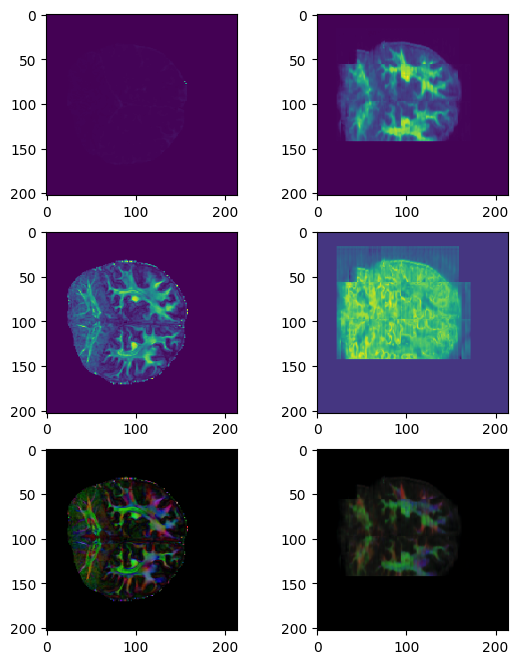

In [61]:
fig ,ax = plt.subplots(3,2)
fig.set_figheight(8)
ax[0][0].imshow(hr_tensor.cpu()[:,80,:,0])
ax[0][1].imshow(rec[:,80,:,0])

ax[1][0].imshow(hr_tensor.cpu()[:,80,:,1])
ax[1][1].imshow(rec[:,80,:,1])

ax[2][0].imshow(hr_tensor.cpu()[:,80,:,2:])
ax[2][1].imshow(rec[:,80,:,2:])
# plt.show()